In [201]:
!pip install ucimlrepo

In [202]:
!pip install torcheval

In [203]:
!pip install SALib

In [204]:
!pip install torchviz

In [205]:
import pandas as pd
import torch
import SALib
import SALib.sample.finite_diff
import SALib.analyze.dgsm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval import metrics
from ucimlrepo import fetch_ucirepo
from torchviz import make_dot

In [206]:
torch.manual_seed(2024)
torch.use_deterministic_algorithms(True)

In [207]:
class BreastCancerNN(nn.Module):
  def __init__(self, num_features, hidden_sizes, output_size):
    super(BreastCancerNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(num_features, hidden_sizes[0]),
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU()
    )
    self.out = nn.Linear(hidden_sizes[1], output_size)
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out(x)
    return self.softmax(x)

In [208]:
from sklearn.utils import shuffle

random_shuffle_state = 2024


def shuffle_train_valid_test_split(dataset: TensorDataset, valid_p=0.1, test_p=0.3):
    dataset = TensorDataset(
        *shuffle(*dataset.tensors, random_state=random_shuffle_state))

    train_offset = int(len(dataset) * (1 - (test_p + valid_p)))
    valid_offset = int(len(dataset) * valid_p) + train_offset

    return {
        "train": TensorDataset(*dataset[:train_offset]),
        "valid": TensorDataset(*dataset[train_offset:valid_offset]),
        "test":  TensorDataset(*dataset[valid_offset:])
    }

In [209]:
def model_train(datasets, model, criterion, optimizer):
  losses = []
  val_accuracy = []
  val_losses = []

  train_samples = len(datasets["train"])
  val_samples = len(datasets["valid"])

  train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

  for epoch in range(20):
      running_loss = 0.0

      model.train()
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      losses.append(running_loss / train_samples)

      model.eval()
      with torch.no_grad():
          inputs, targets = datasets["valid"][:]
          outputs = model(inputs)

          acc = metrics.functional.multiclass_accuracy(outputs, targets)
          loss = criterion(outputs, targets)

          val_accuracy.append(acc)
          val_losses.append(loss / val_samples)
  return losses, val_losses, val_accuracy

In [210]:
def plot_loss_accuracy(dataset_name, losses, val_losses, val_accuracy):
  plt.plot(losses, label=f'{dataset_name} loss')
  plt.plot(val_losses, label=f'{dataset_name} validation loss')
  plt.legend()
  plt.show()
  plt.plot(val_accuracy, label=f'{dataset_name} validation accuracy')
  plt.legend()
  plt.show()

In [211]:
def wrapped_model(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float)
    with torch.no_grad():
        return model(inputs).detach().numpy()

In [212]:
def analyze_dgsm(headers):
  problem = SALib.ProblemSpec({
      "num_vars": len(headers),
      "names": headers,
      "bounds": [[-1., 1.]] * len(headers),
  })

  problem.items()

  problem.sample(SALib.sample.finite_diff.sample, N=1024)
  problem.evaluate(wrapped_model)
  problem.analyze(SALib.analyze.dgsm.analyze)

  print(problem)
  return problem

In [213]:
def analyze_fast(headers):
  problem = SALib.ProblemSpec({
      "num_vars": len(headers),
      "names": headers,
      "bounds": [[-1., 1.]] * len(headers),
  })

  problem.items()

  problem.sample(SALib.sample.fast_sampler.sample, N=1024, seed = 2024)
  problem.evaluate(wrapped_model)
  problem.analyze(SALib.analyze.fast.analyze)

  print(problem)
  return problem

In [214]:
def show_stats(problem, mode="dgsm"):
  stats: pd.DataFrame = sum(problem.to_df())  # sum analysis over target classes
  print(stats)
  min_index = stats[mode].argmin()
  min_index, stats.iloc[min_index]

In [215]:
def dgsm_remove_headers(datasets, headers, model_factory, optimizer_factory, criterion):
  dropped_headers = []

  test_accs = []

  models = []

  # removing features loop
  while len(headers) > 0:
      model = model_factory(headers)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_figwidth(10)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.ylim(0, 1)
      plt.legend()
      plt.show()

      print(f"Test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if len(headers) <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": len(headers),
          "names": headers,
          "bounds": [[-1., 1.]] * len(headers),
          "dists": ["norm"] * len(headers)
      })

      problem.sample(SALib.sample.finite_diff.sample, N=4096)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.dgsm.analyze)

      min_index = sum(problem.to_df())['dgsm'].argmin()

      indexes = torch.arange(len(headers)) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_headers.append((min_index, headers[min_index]))
      print(f"dropping feature: {dropped_headers[-1]}")
      del headers[min_index]

      print("="*50)
  return test_accs, dropped_headers, models

In [216]:
def fast_remove_headers(datasets, headers, model_factory, optimizer_factory, criterion):
  dropped_headers = []

  test_accs = []

  models = []

  # removing features loop
  while len(headers) > 0:
      model = model_factory(headers)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_figwidth(10)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.ylim(0, 1)
      plt.legend()
      plt.show()

      print(f"Test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if len(headers) <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": len(headers),
          "names": headers,
          "bounds": [[-1., 1.]] * len(headers),
          "dists": ["norm"] * len(headers)
      })

      problem.sample(SALib.sample.fast_sampler.sample, N=1024, seed = 2024)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.fast.analyze)

      min_index = sum(problem.to_df())['ST'].argmin()

      indexes = torch.arange(len(headers)) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_headers.append((min_index, headers[min_index]))
      print(f"dropping feature: {dropped_headers[-1]}")
      del headers[min_index]

      print("="*50)
  return test_accs, dropped_headers, models

In [217]:
def dgsm_remove_neurons(datasets, initial_hidden_size, model_factory, optimizer_factory, criterion):
  hidden_size = initial_hidden_size
  dropped_neurons = []
  test_accs = []
  models = []

  # removing features loop
  while hidden_size > 0:
      model = model_factory(1, hidden_size)
      model.layer1 = nn.Identity()
      # model.load_state_dict(state_dict)

      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_size_inches(10, 5)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.legend()
      plt.show()

      print(f"dropped: {len(dropped_neurons)}, test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if hidden_size <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": hidden_size,
          "names": [f"x{i}" for i in range(hidden_size)],
          "bounds": [[-1., 1.]] * hidden_size,
      })

      problem.sample(SALib.sample.finite_diff.sample, N=2048)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.dgsm.analyze)

      min_index = sum(problem.to_df())['dgsm'].argmin()

      indexes = torch.arange(hidden_size) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_neurons.append(min_index)
      hidden_size -= 1

      print("="*50)
  return test_accs, dropped_neurons, models

In [218]:
def fast_remove_neurons(datasets, initial_hidden_size, model_factory, optimizer_factory, criterion, is_layer_1 = True):
  hidden_size = initial_hidden_size
  dropped_neurons = []
  test_accs = []
  models = []

  # removing features loop
  while hidden_size > 0:
      model = model_factory(1, hidden_size)
      model.layer1 = nn.Identity()
      # model.load_state_dict(state_dict)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])
      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)
          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)
      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)
      # feel free to edit
      plt.gcf().set_size_inches(10, 5)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.legend()
      plt.show()

      print(f"dropped: {len(dropped_neurons)}, test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if hidden_size <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy();

      problem = None
      if is_layer_1:
        problem = SALib.ProblemSpec({
          "num_vars": hidden_size,
          "names": [f"x{i}" for i in range(hidden_size)],
          "bounds": [[-1., 1.]] * hidden_size,
        })
      else:
        problem = SALib.ProblemSpec({
          "num_vars": initial_hidden_size,
          "names": [f"x{i}" for i in range(initial_hidden_size)],
          "bounds": [[-1., 1.]] * initial_hidden_size,
        })
      problem.sample(SALib.sample.fast_sampler.sample, N=2048, seed = 2024)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.fast.analyze)

      min_index = sum(problem.to_df())['ST'].argmin()

      indexes = torch.arange(hidden_size) != min_index
      if is_layer_1:
        datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
        }

      dropped_neurons.append(min_index)
      hidden_size -= 1

      print("="*50)
  return test_accs, dropped_neurons, models

In [219]:
def pick_features_to_drop(headers, dropped_headers, models, datasets, num_drop_features):
  reduced_headers = headers.copy()
  indexes = list(range(len(reduced_headers)))
  for idx, _ in dropped_headers[:num_drop_features]:
      del indexes[idx]
      del reduced_headers[idx]

  reduced_datasets = {
      key: TensorDataset(
          dataset.tensors[0][:, indexes],
          dataset.tensors[1]
      )
      for key, dataset in datasets.items()
  }

  best_model = models[num_drop_features]

  print(f"[{len(reduced_headers)}] features left:", reduced_headers)

  return best_model, reduced_datasets

In [220]:
def pick_neurons_to_drop(num_drop_neurons, hidden_size, dropped_neurons, best_model, models, layer_num = 1):
  indexes = list(range(hidden_size))
  for idx in dropped_neurons[:num_drop_neurons]:
      del indexes[idx]

  reduced_datasets = {
    key: TensorDataset(
        dataset.tensors[0][:, indexes],
        dataset.tensors[1]
    )
    for key, dataset in datasets.items()
  }

  layer1 = best_model.layer1
  state_dict = layer1[0].state_dict()
  layer1[0] = nn.Linear(
      in_features=layer1[0].in_features,
      out_features=len(indexes)
  )
  state_dict["bias"] = state_dict["bias"][indexes]
  state_dict["weight"] = state_dict["weight"][indexes, :]
  layer1[0].load_state_dict(state_dict)

  new_best_model = models[num_drop_neurons]
  new_best_model.layer1 = layer1

  # TO_FINISH!!
  # if layer_num == 2:
  #   layer2 = best_model.layer2
  #   state_dict = layer2[0].state_dict()
  #   layer2[0] = nn.Linear(
  #       in_features=layer2[0].in_features,
  #       out_features=len(indexes)
  #   )
  #   print(indexes)
  #   state_dict["bias"] = state_dict["bias"][indexes]
  #   state_dict["weight"] = state_dict["weight"][indexes, :]
  #   layer2[0].load_state_dict(state_dict)

  #   new_best_model = models[num_drop_neurons]
  #   new_best_model.layer2 = layer2
  return new_best_model, reduced_datasets

In [221]:
def model_pre_train(base_model, criterion, optimizer_factory, datasets):
  base_model.layer1 = nn.Identity()

  train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

  optimizer = optimizer_factory(base_model)

  # pretrain
  base_model.train()
  for epoch in range(5):
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = base_model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

In [222]:
# import breast cancer dataset
breast_cancer = fetch_ucirepo(id=17)

In [223]:
breast_cancer_scaler = StandardScaler()
breast_cancer_dataset = TensorDataset(
    torch.tensor(breast_cancer_scaler.fit_transform(
        breast_cancer.data.features), dtype=torch.float),
    torch.tensor(breast_cancer.data.targets['Diagnosis'] == 'M', dtype=torch.long).flatten()
)

breast_cancer_datasets = shuffle_train_valid_test_split(breast_cancer_dataset)
breast_cancer_headers: list = breast_cancer.data.headers[1:-1].to_list()

In [224]:
datasets = breast_cancer_datasets

model = BreastCancerNN(breast_cancer.data.features.shape[1], (32, 32), 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [225]:
losses, val_losses, val_accuracy = model_train(datasets, model, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


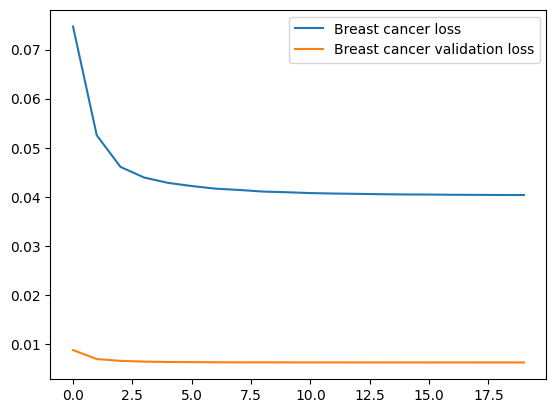

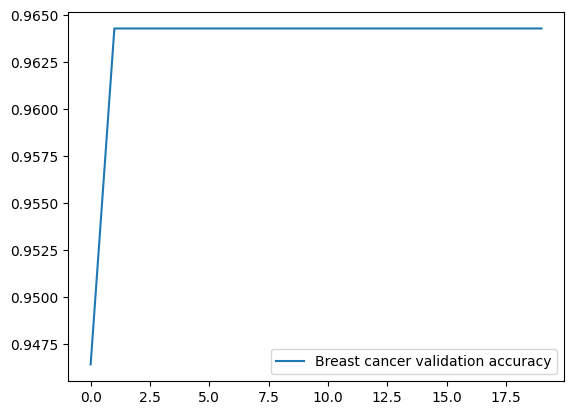

In [226]:
plot_loss_accuracy('Breast cancer', losses, val_losses, val_accuracy)

## DGSM

In [227]:
problem = analyze_dgsm(breast_cancer_headers)
show_stats(problem)
datasets = breast_cancer_datasets.copy()
headers = breast_cancer_headers.copy()
model_factory = lambda headers : BreastCancerNN(len(headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Samples:
	30 parameters: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
	31744 samples
Outputs:
	2 outputs: ['Y1', 'Y2']
	31744 evaluations
Analysis:
Y1:
                          vi    vi_std      dgsm  dgsm_conf
radius1             0.017912  0.042901  0.039888   0.002674
texture1            0.028757  0.063893  0.064039   0.004234
perimeter1          0.010228  0.025876  0.022777   0.001709
area1               0.064876  0.139626  0.144471   0.008772
smoothness1         0.020073  0.048178  0.044701   0.003121
compactness1        0.003791  0.010674  0.008441   0.000620
concavity1          0.047798  0.10385

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


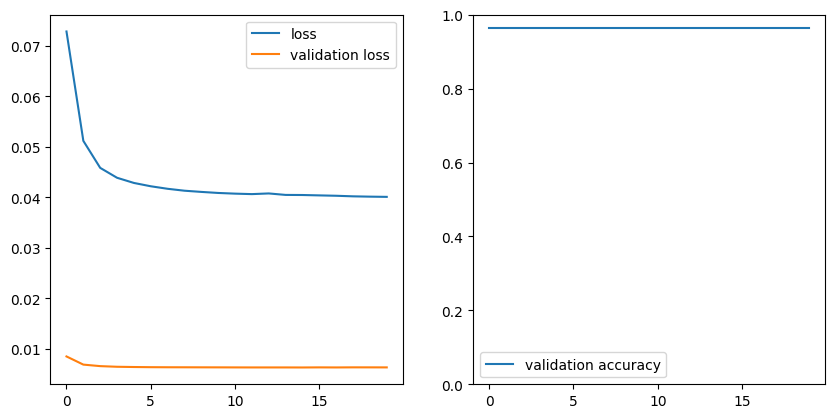

Test: loss: 0.35077258944511414, accuracy: 0.9593023061752319
dropping feature: (11, 'texture2')


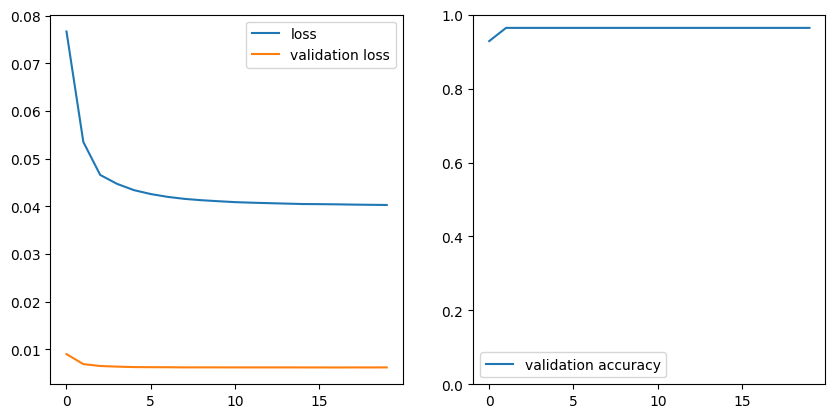

Test: loss: 0.34644365310668945, accuracy: 0.9593023061752319
dropping feature: (8, 'symmetry1')


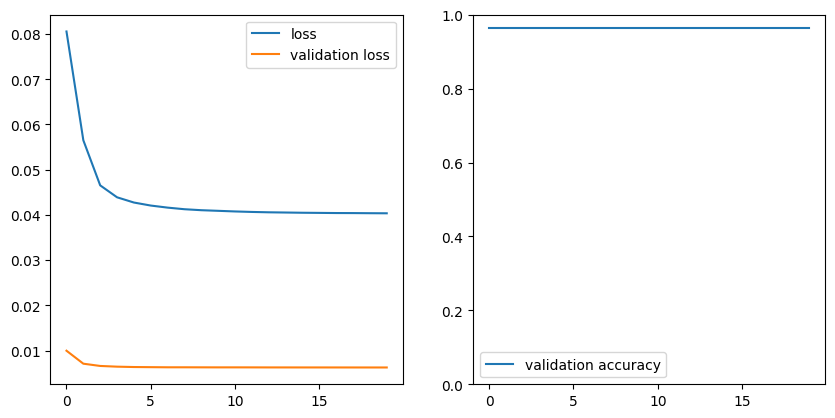

Test: loss: 0.34619420766830444, accuracy: 0.9651162624359131
dropping feature: (12, 'smoothness2')


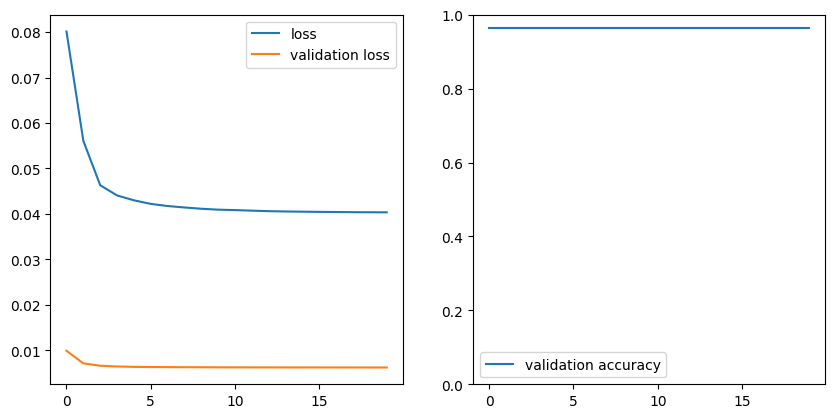

Test: loss: 0.3436134159564972, accuracy: 0.9709302186965942
dropping feature: (14, 'concave_points2')


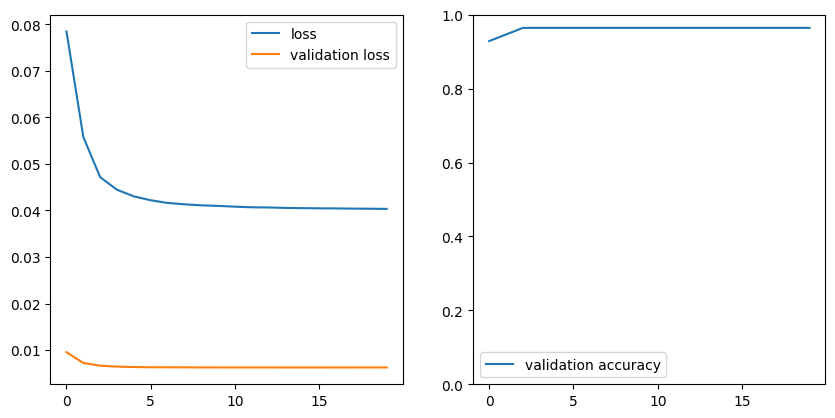

Test: loss: 0.3449578285217285, accuracy: 0.9651162624359131
dropping feature: (15, 'fractal_dimension2')


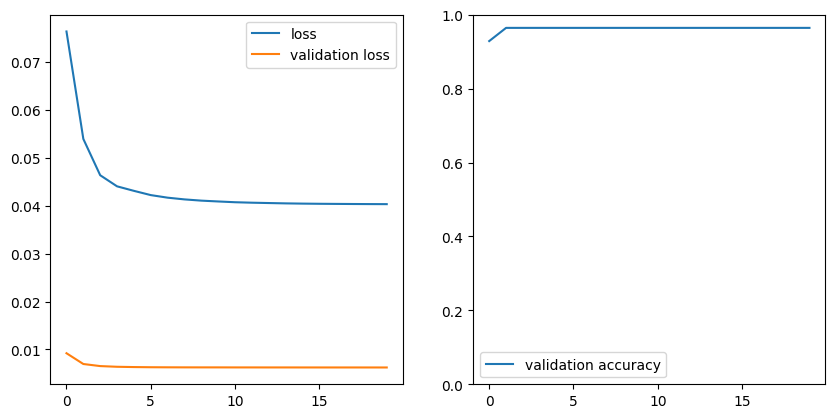

Test: loss: 0.34836387634277344, accuracy: 0.9651162624359131
dropping feature: (5, 'compactness1')


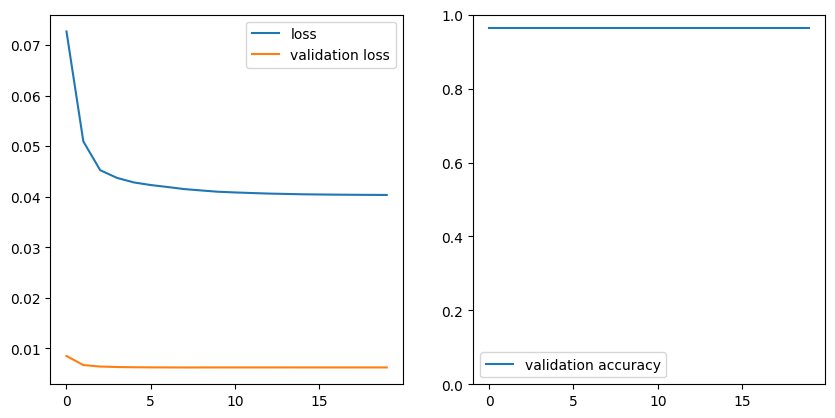

Test: loss: 0.3444560170173645, accuracy: 0.9651162624359131
dropping feature: (19, 'compactness3')


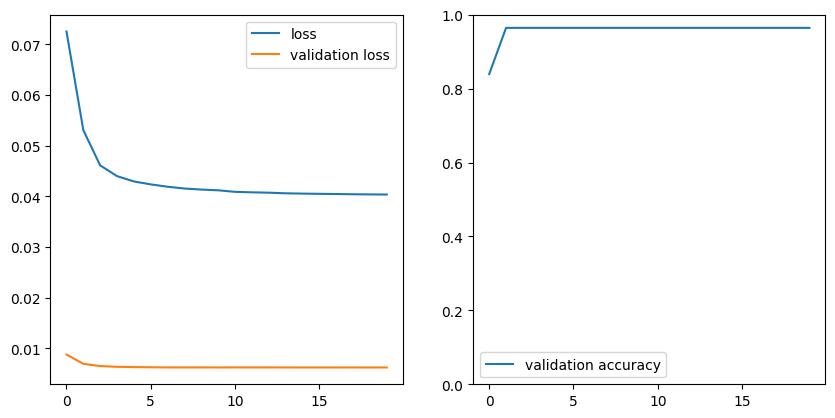

Test: loss: 0.3483545482158661, accuracy: 0.9593023061752319
dropping feature: (22, 'fractal_dimension3')


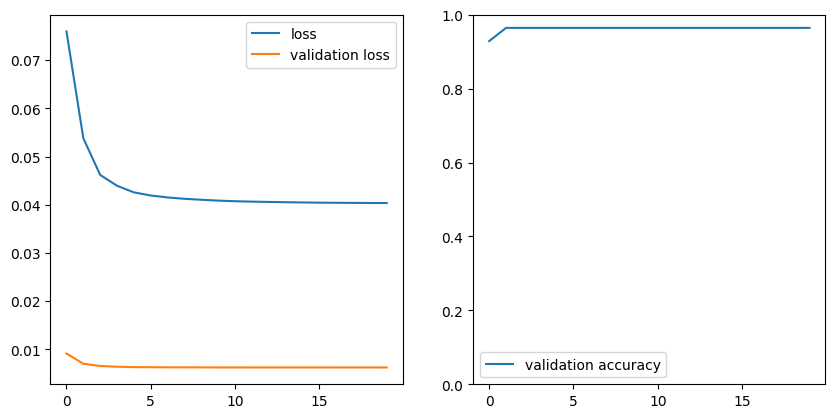

Test: loss: 0.34146496653556824, accuracy: 0.9709302186965942
dropping feature: (13, 'symmetry2')


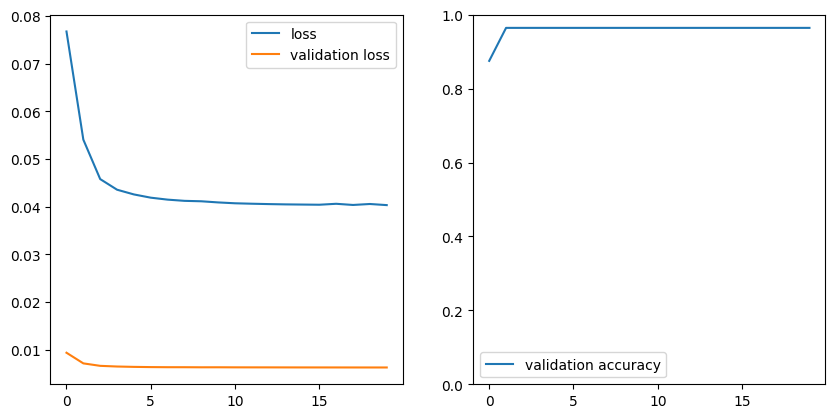

Test: loss: 0.3411942720413208, accuracy: 0.9709302186965942
dropping feature: (12, 'concavity2')


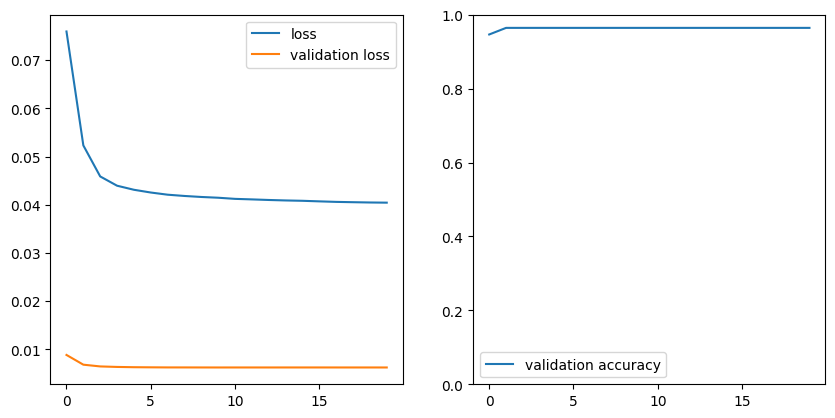

Test: loss: 0.3384304642677307, accuracy: 0.9709302186965942
dropping feature: (18, 'concave_points3')


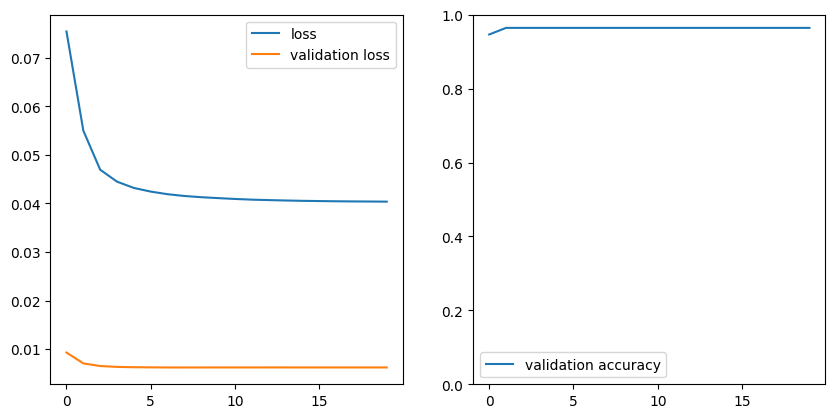

Test: loss: 0.33870774507522583, accuracy: 0.9709302186965942
dropping feature: (9, 'perimeter2')


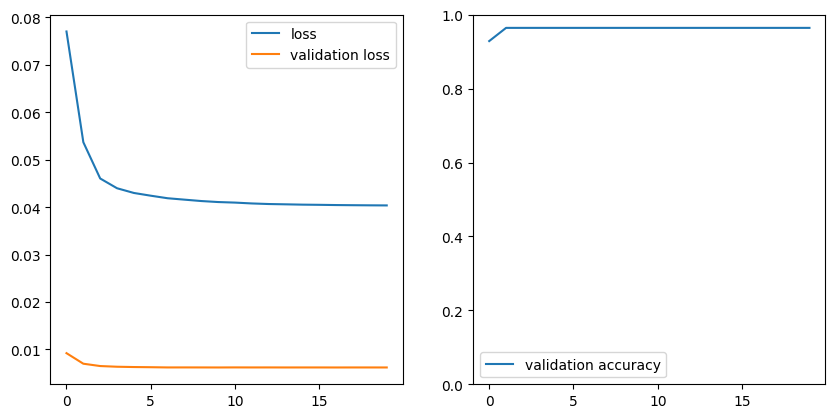

Test: loss: 0.3412519097328186, accuracy: 0.9709302186965942
dropping feature: (17, 'symmetry3')


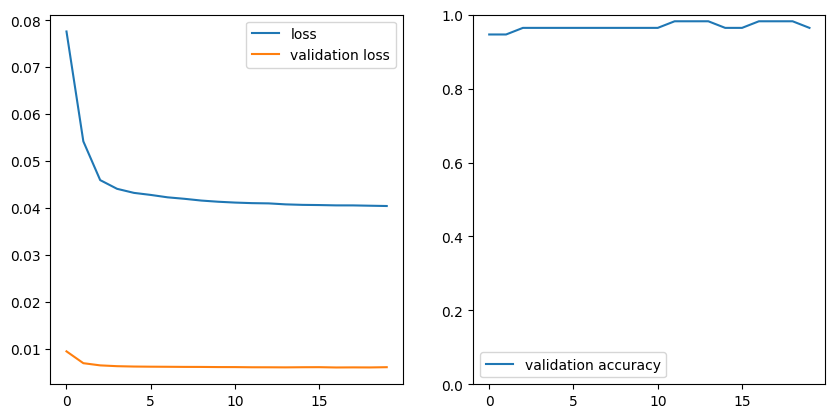

Test: loss: 0.34484928846359253, accuracy: 0.9709302186965942
dropping feature: (7, 'fractal_dimension1')


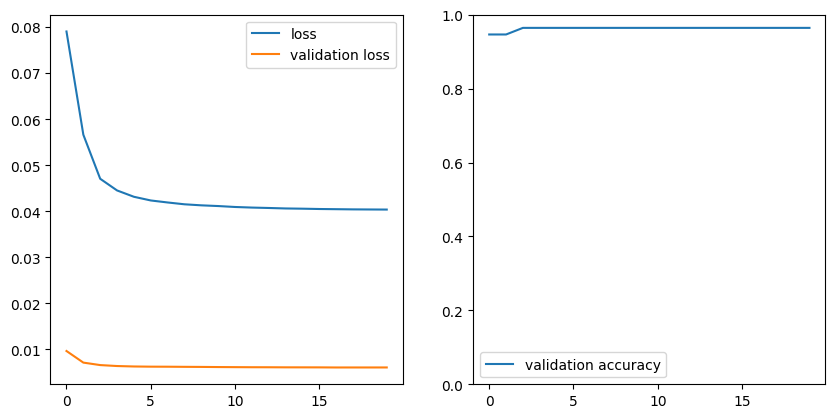

Test: loss: 0.33999109268188477, accuracy: 0.9767441749572754
dropping feature: (5, 'concavity1')


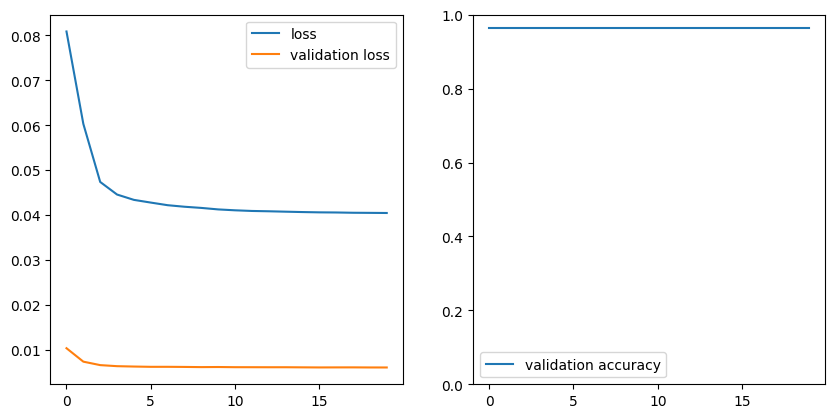

Test: loss: 0.34077128767967224, accuracy: 0.9767441749572754
dropping feature: (1, 'texture1')


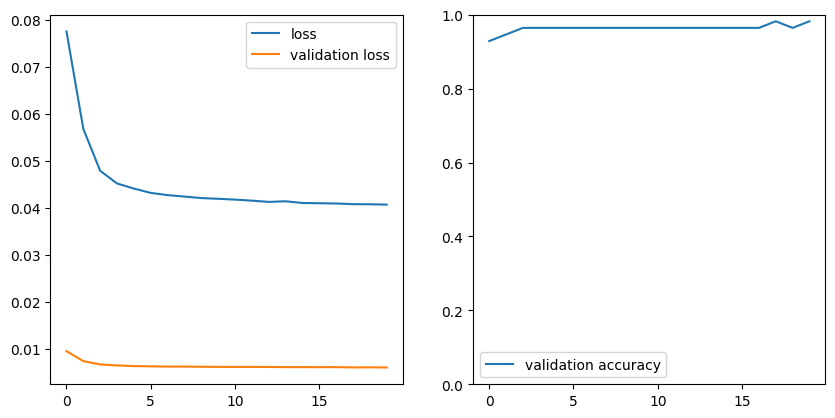

Test: loss: 0.34483733773231506, accuracy: 0.9651162624359131
dropping feature: (1, 'perimeter1')


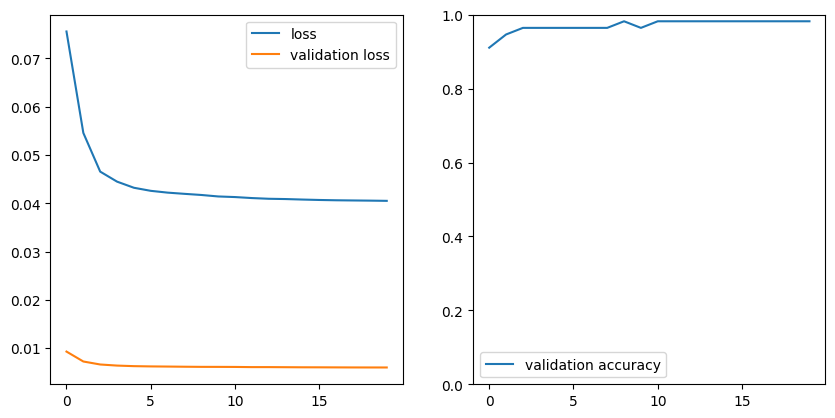

Test: loss: 0.3440482020378113, accuracy: 0.9709302186965942
dropping feature: (2, 'smoothness1')


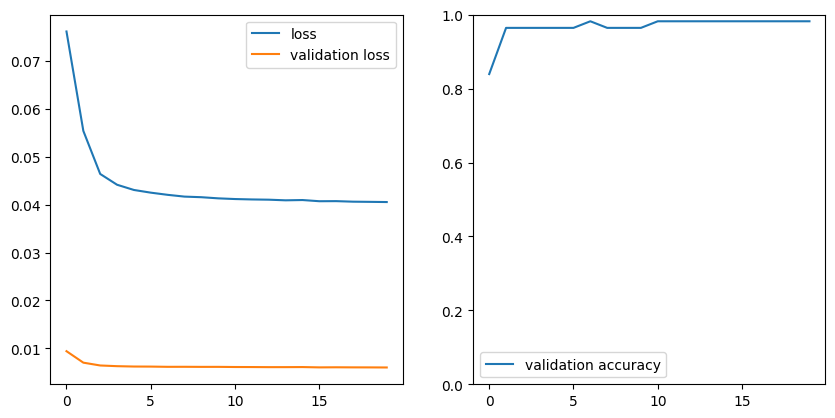

Test: loss: 0.3434981107711792, accuracy: 0.9709302186965942
dropping feature: (5, 'compactness2')


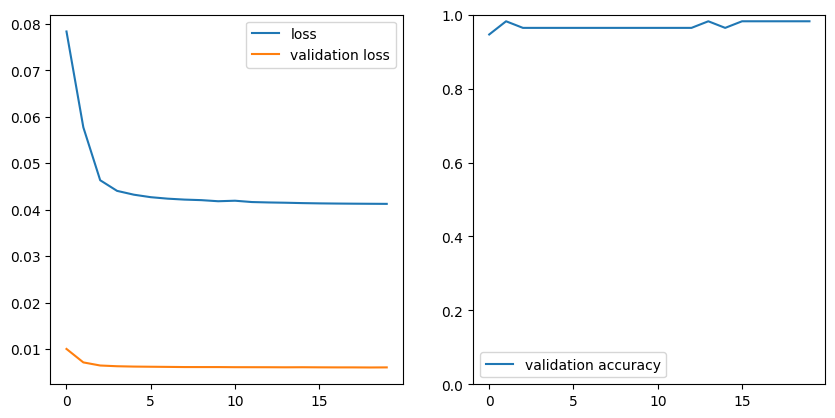

Test: loss: 0.3402479887008667, accuracy: 0.9651162624359131
dropping feature: (3, 'radius2')


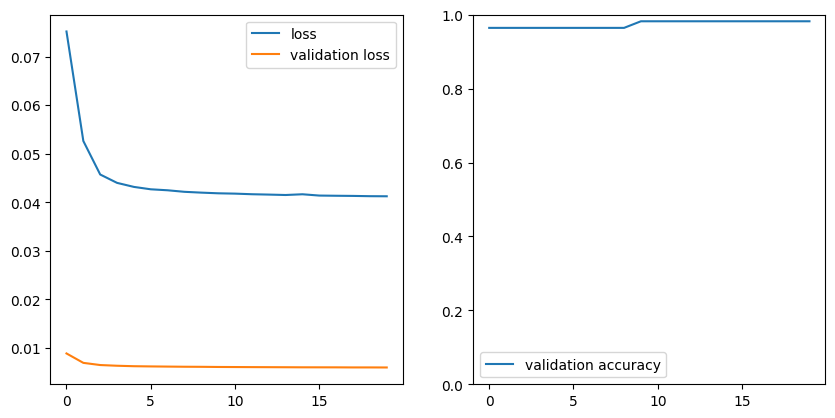

Test: loss: 0.3386741876602173, accuracy: 0.9709302186965942
dropping feature: (2, 'concave_points1')


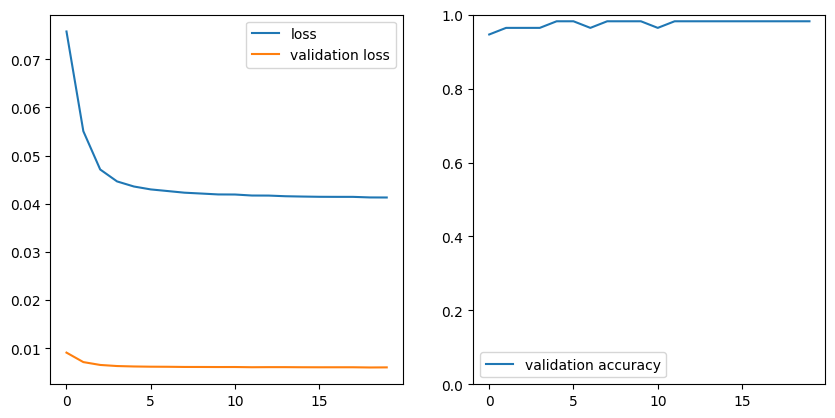

Test: loss: 0.3380682170391083, accuracy: 0.9767441749572754
dropping feature: (5, 'perimeter3')


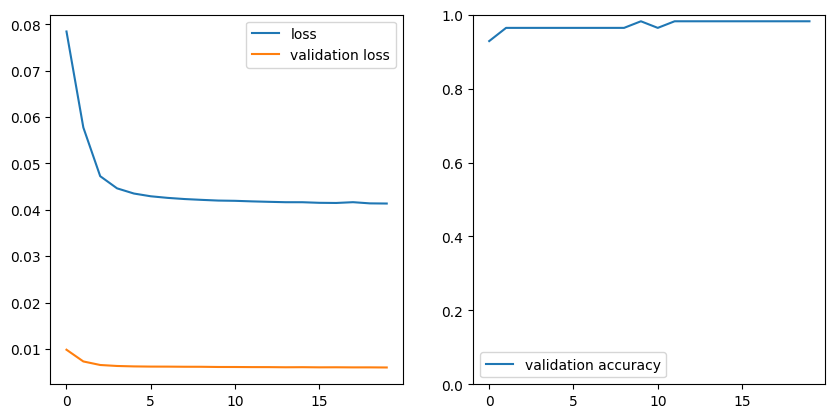

Test: loss: 0.33826616406440735, accuracy: 0.9767441749572754
dropping feature: (4, 'texture3')


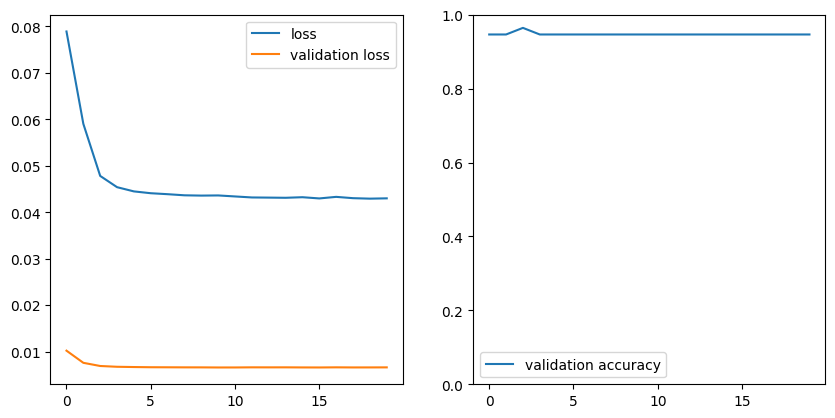

Test: loss: 0.3566257357597351, accuracy: 0.9534883499145508
dropping feature: (0, 'radius1')


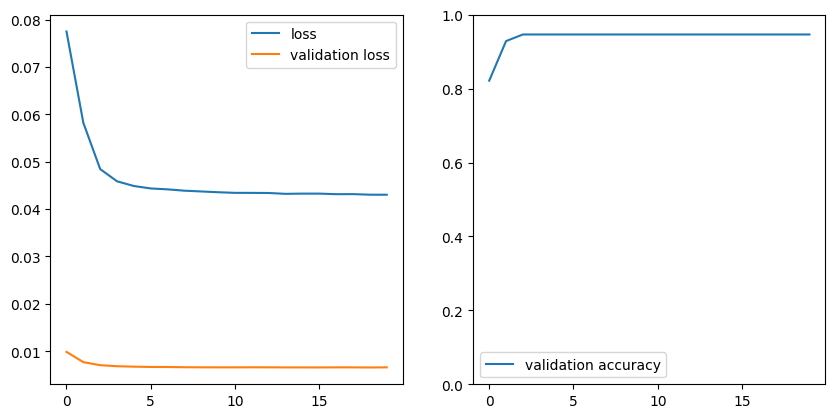

Test: loss: 0.35639655590057373, accuracy: 0.9534883499145508
dropping feature: (0, 'area1')


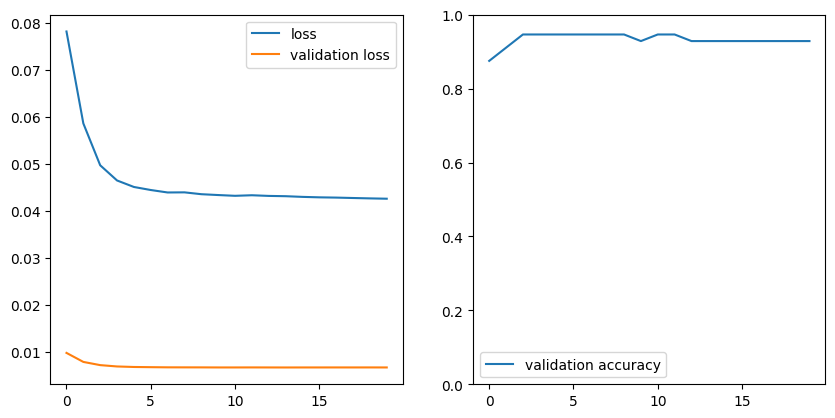

Test: loss: 0.35319972038269043, accuracy: 0.9593023061752319
dropping feature: (3, 'smoothness3')


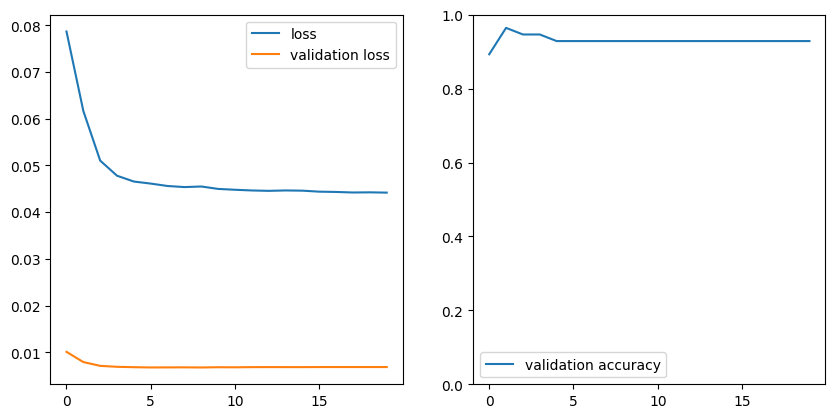

Test: loss: 0.3812246024608612, accuracy: 0.930232584476471
dropping feature: (0, 'area2')


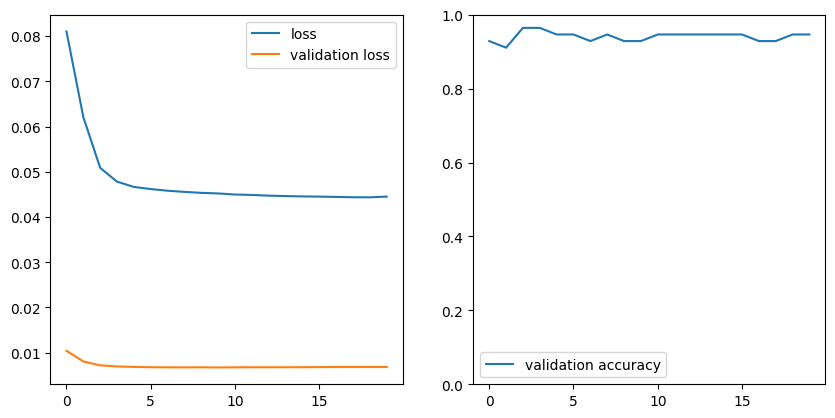

Test: loss: 0.3801313042640686, accuracy: 0.930232584476471
dropping feature: (0, 'radius3')


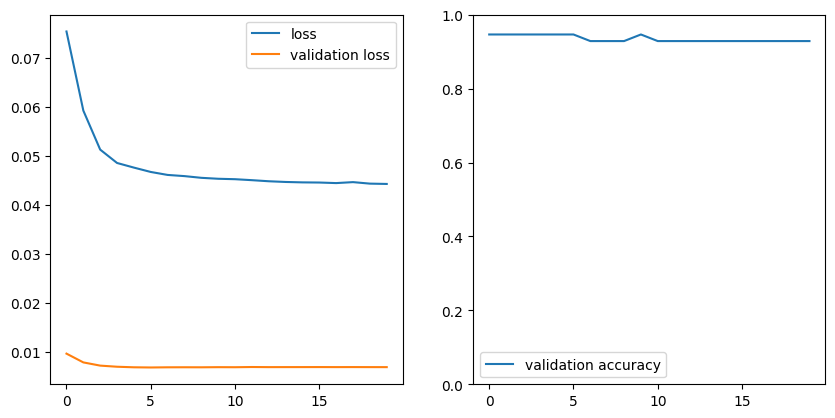

Test: loss: 0.3852941393852234, accuracy: 0.9127907156944275
dropping feature: (1, 'concavity3')


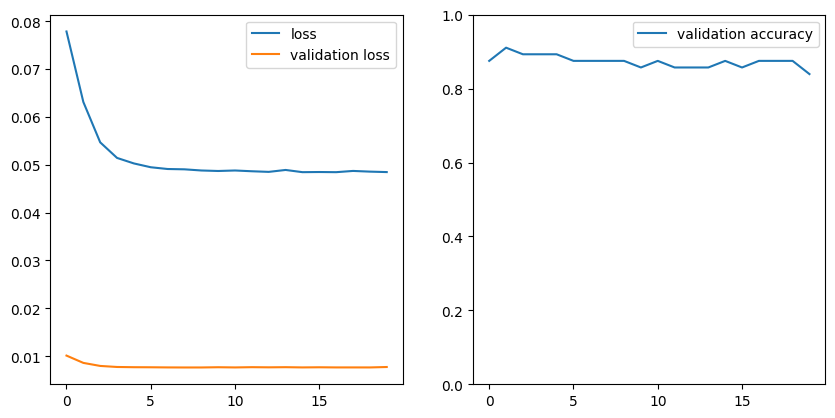

Test: loss: 0.4030500054359436, accuracy: 0.9127907156944275


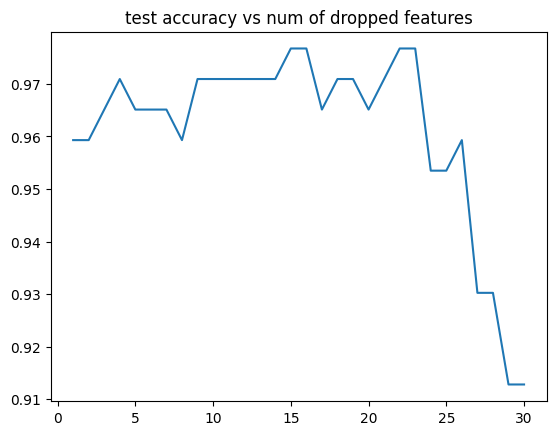

In [228]:
test_accs, dropped_headers, models = dgsm_remove_headers(datasets, headers, model_factory, optimizer_factory ,criterion)
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped features")
plt.show()

In [229]:
reduced_headers = breast_cancer_headers.copy()
datasets = breast_cancer_datasets
num_drop_features = 22
best_model, reduced_datasets = pick_features_to_drop(reduced_headers, dropped_headers, models, datasets, num_drop_features)

[8] features left: ['radius1', 'area1', 'area2', 'radius3', 'texture3', 'area3', 'smoothness3', 'concavity3']


In [230]:
layer: nn.Module = best_model.layer1
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

In [231]:
# not needed in this model, maybe usefull in bigger one to save some traning time? to be tested
# will need acrobatics for sure (tweaking state_dict)
base_model = BreastCancerNN(len(breast_cancer_headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_pre_train(base_model, criterion, optimizer_factory, datasets)

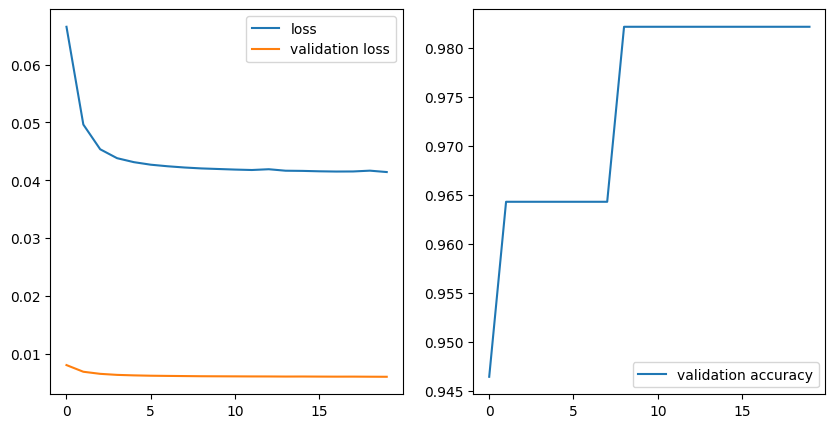

dropped: 0, test: loss: 0.3387930989265442, accuracy: 0.9767441749572754


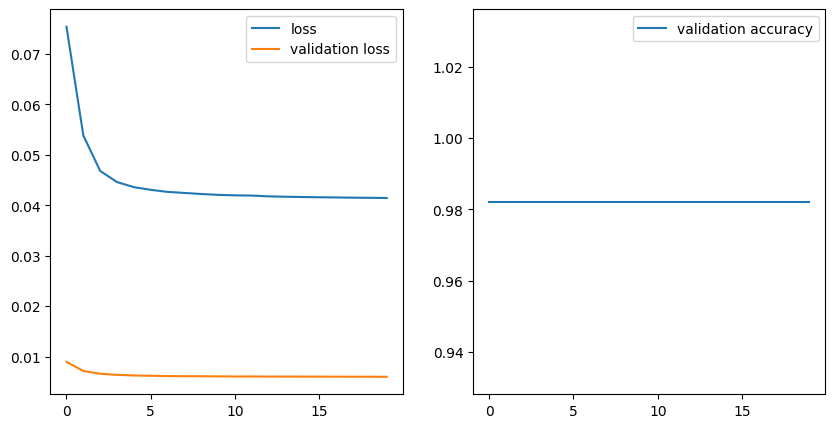

dropped: 1, test: loss: 0.33950120210647583, accuracy: 0.9709302186965942


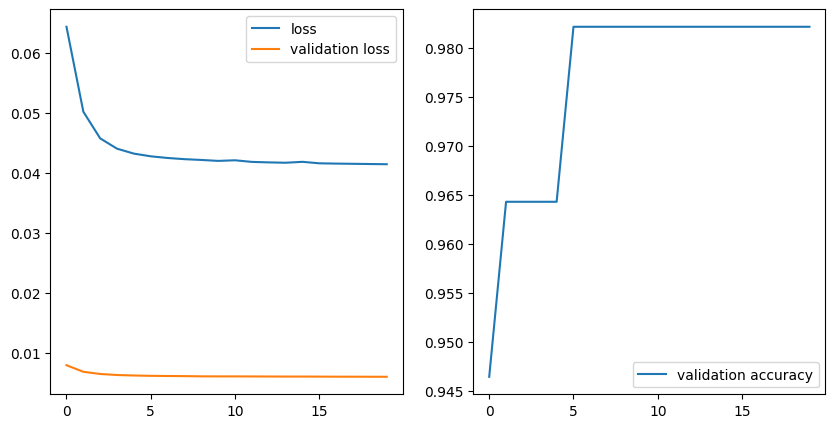

dropped: 2, test: loss: 0.3393675982952118, accuracy: 0.9709302186965942


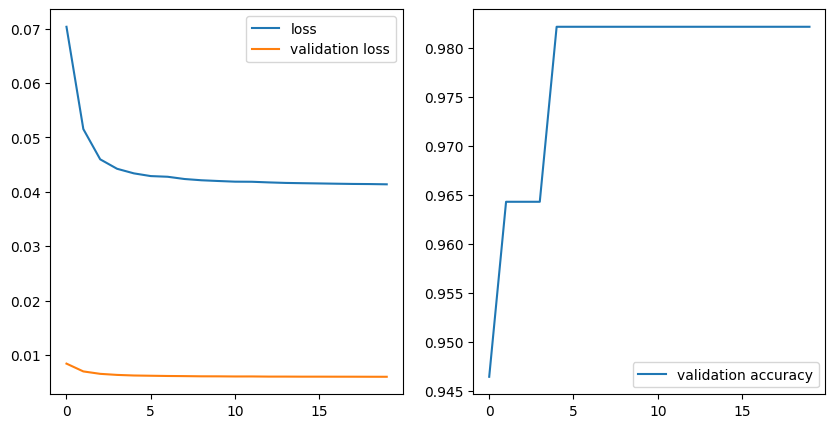

dropped: 3, test: loss: 0.33900898694992065, accuracy: 0.9709302186965942


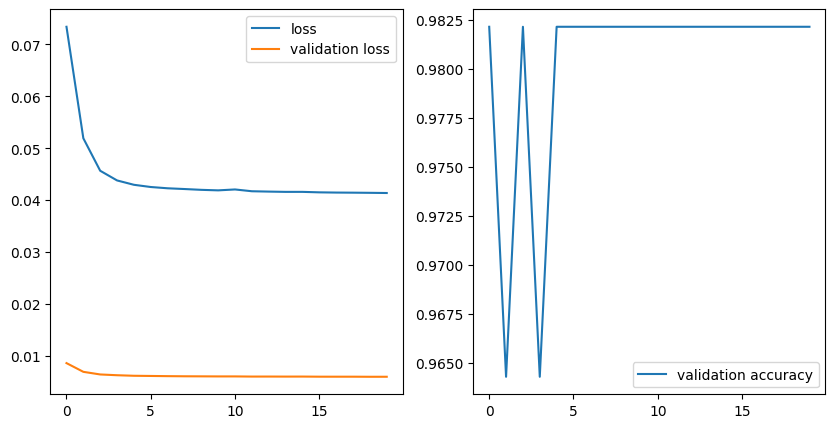

dropped: 4, test: loss: 0.3388966917991638, accuracy: 0.9767441749572754


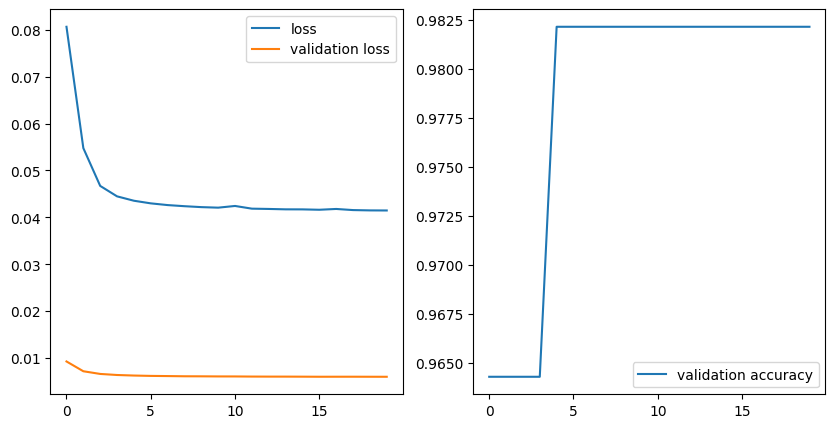

dropped: 5, test: loss: 0.33888888359069824, accuracy: 0.9709302186965942


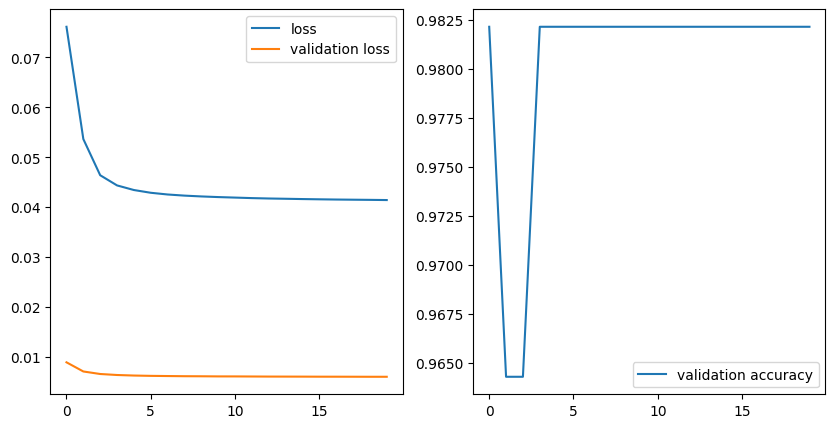

dropped: 6, test: loss: 0.33951061964035034, accuracy: 0.9709302186965942


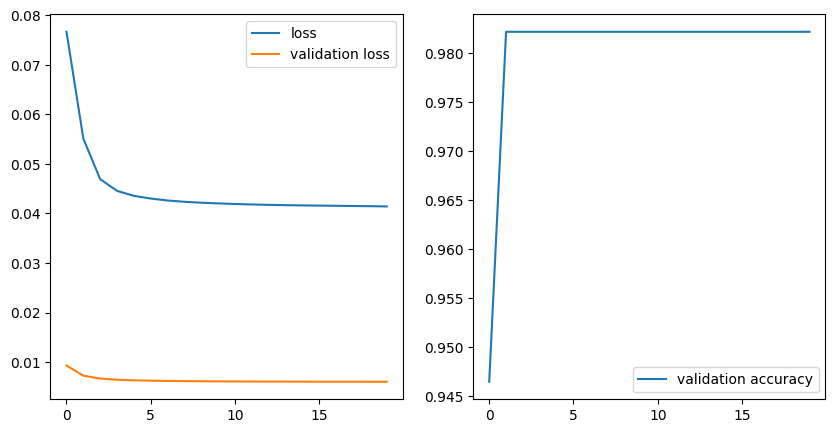

dropped: 7, test: loss: 0.33824050426483154, accuracy: 0.9767441749572754


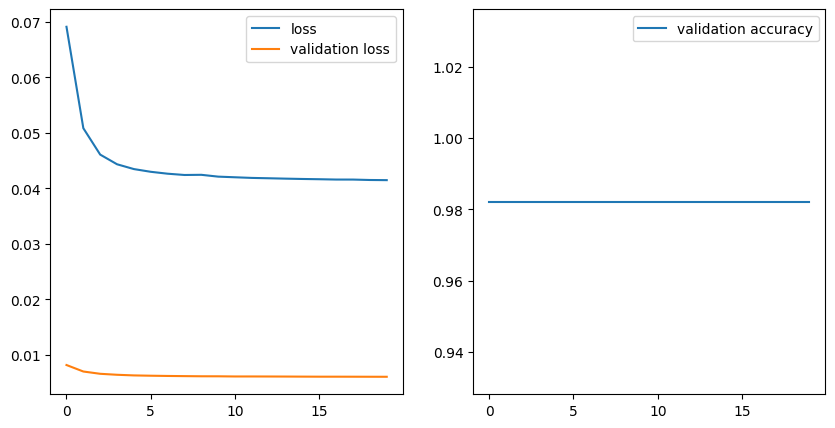

dropped: 8, test: loss: 0.3388606905937195, accuracy: 0.9767441749572754


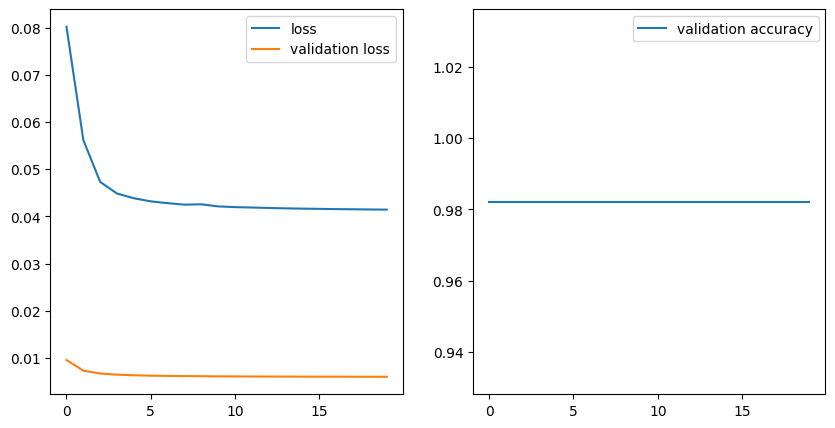

dropped: 9, test: loss: 0.3399544060230255, accuracy: 0.9709302186965942


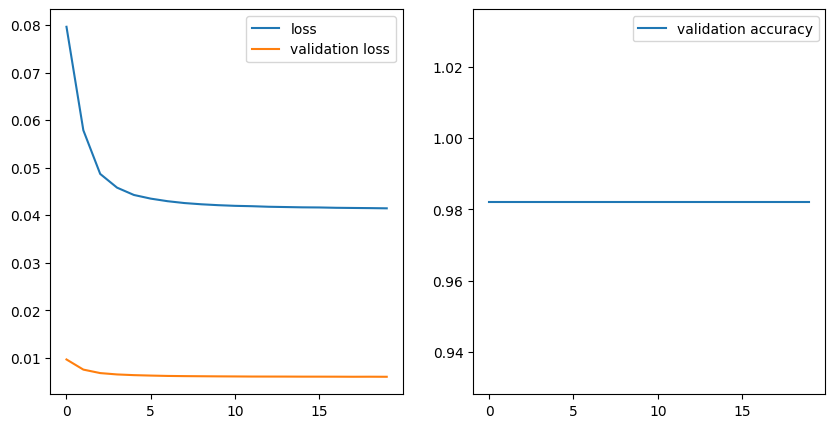

dropped: 10, test: loss: 0.33857589960098267, accuracy: 0.9767441749572754


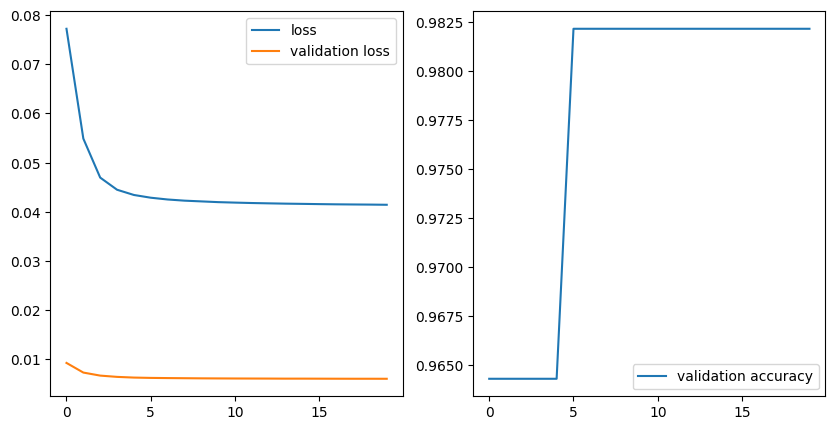

dropped: 11, test: loss: 0.33861494064331055, accuracy: 0.9709302186965942


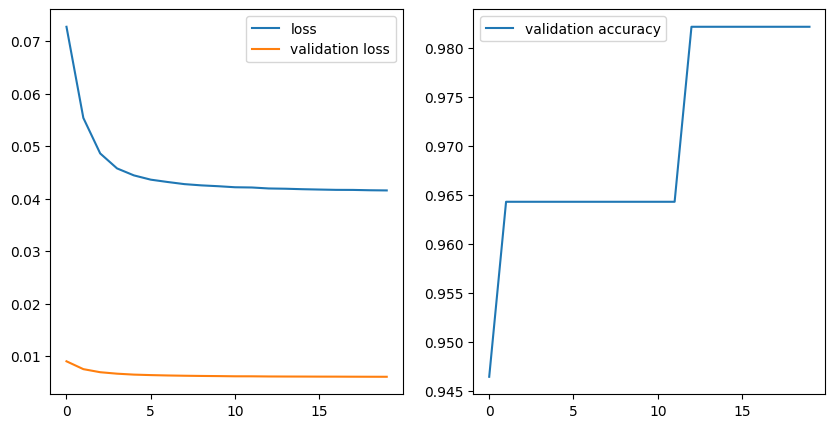

dropped: 12, test: loss: 0.33890601992607117, accuracy: 0.9709302186965942


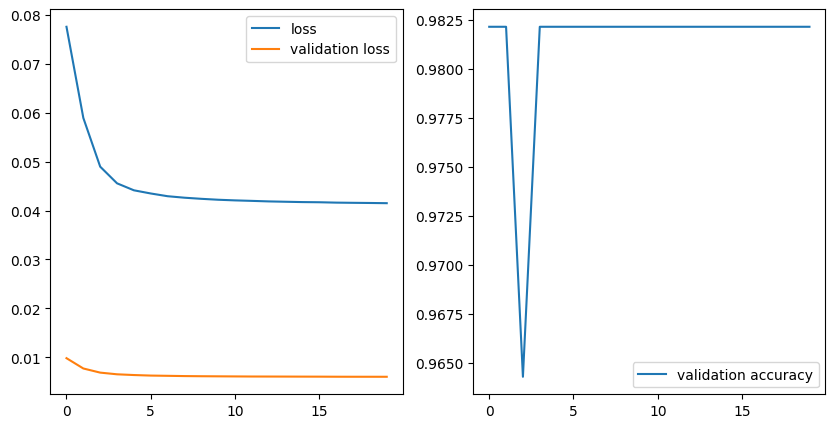

dropped: 13, test: loss: 0.3379596769809723, accuracy: 0.9767441749572754


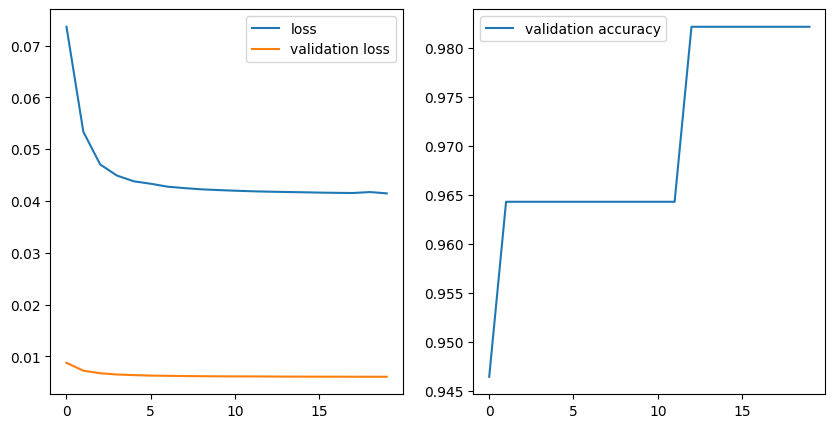

dropped: 14, test: loss: 0.33800628781318665, accuracy: 0.9767441749572754


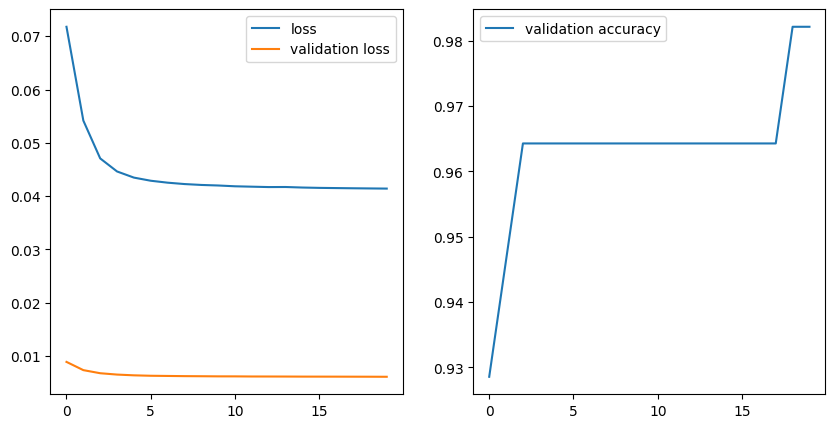

dropped: 15, test: loss: 0.3378789722919464, accuracy: 0.9767441749572754


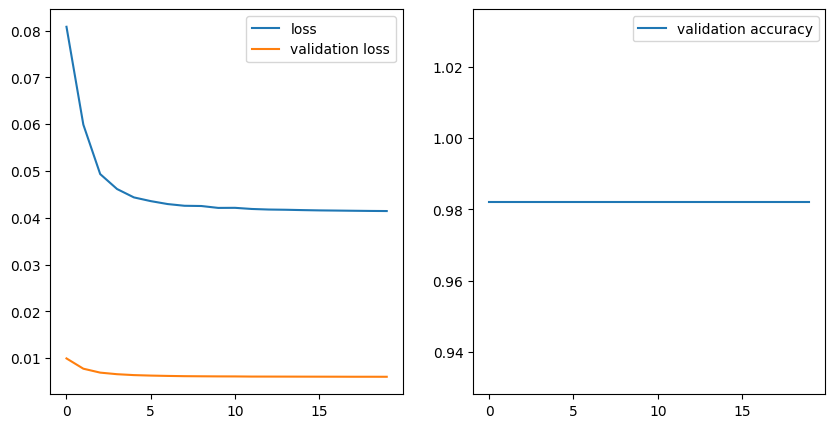

dropped: 16, test: loss: 0.3379811942577362, accuracy: 0.9767441749572754


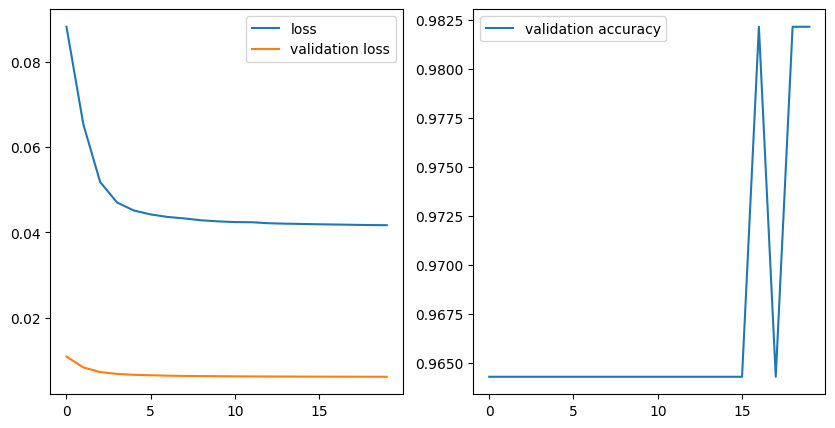

dropped: 17, test: loss: 0.3396516442298889, accuracy: 0.9709302186965942


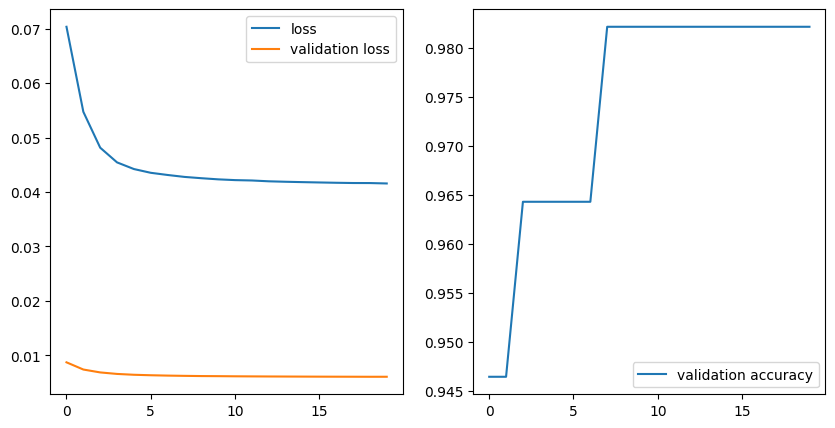

dropped: 18, test: loss: 0.3393690586090088, accuracy: 0.9709302186965942


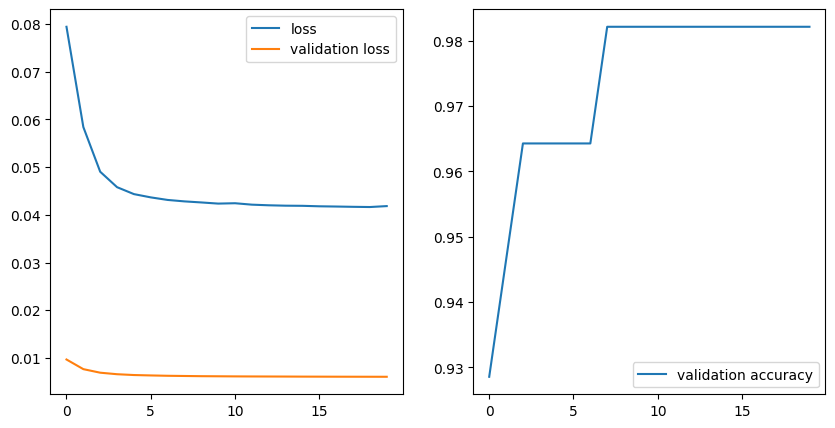

dropped: 19, test: loss: 0.3386106491088867, accuracy: 0.9709302186965942


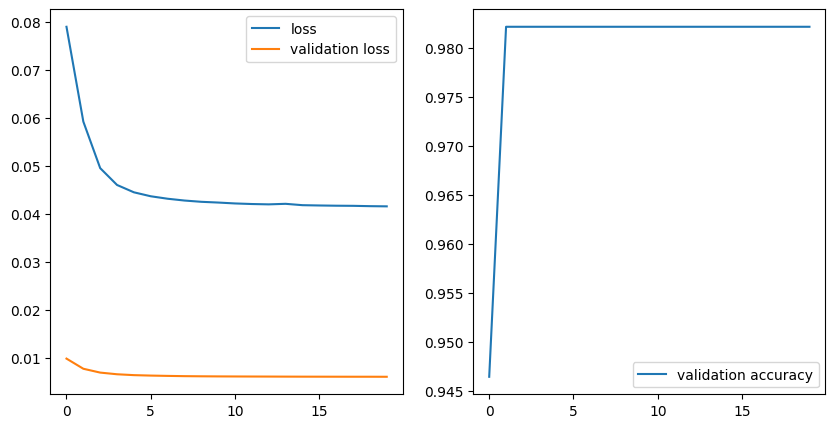

dropped: 20, test: loss: 0.3372013568878174, accuracy: 0.9767441749572754


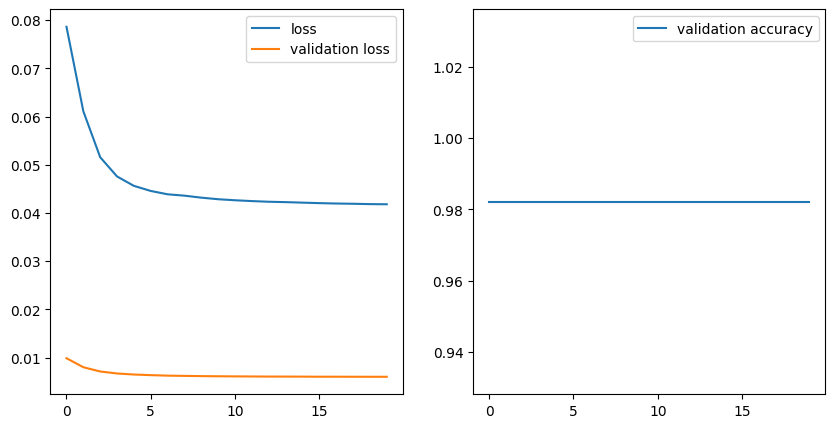

dropped: 21, test: loss: 0.3386519253253937, accuracy: 0.9767441749572754


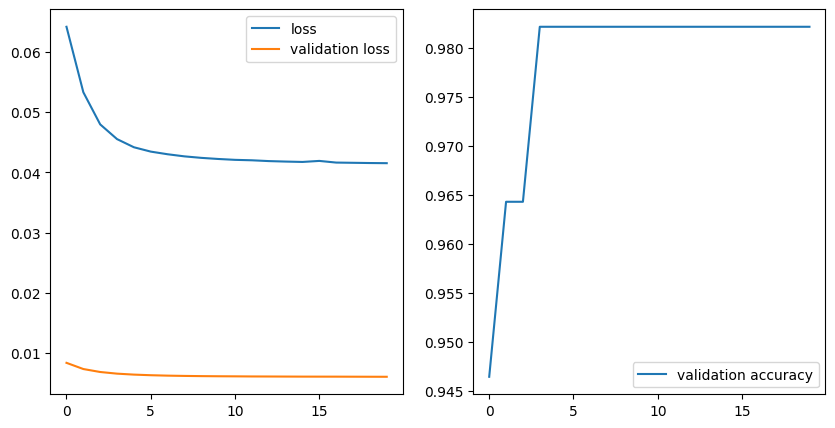

dropped: 22, test: loss: 0.33733388781547546, accuracy: 0.9767441749572754


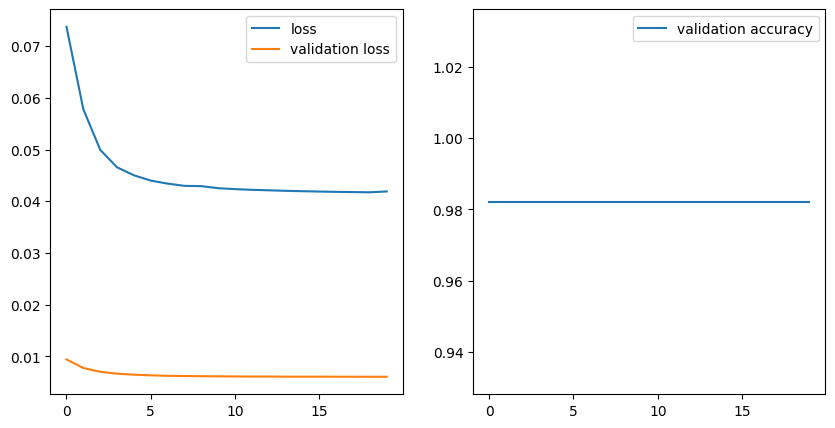

dropped: 23, test: loss: 0.3389691114425659, accuracy: 0.9709302186965942


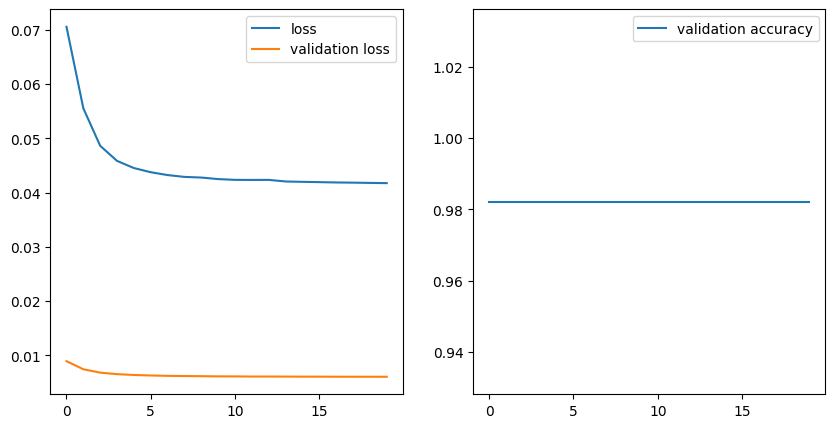

dropped: 24, test: loss: 0.3401297628879547, accuracy: 0.9709302186965942


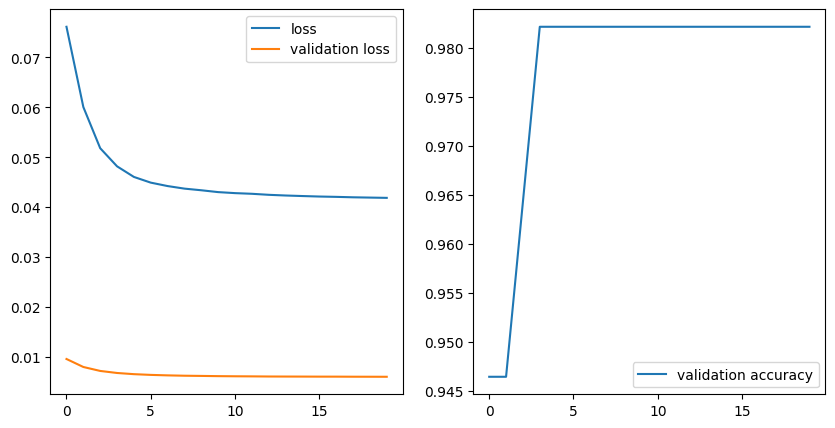

dropped: 25, test: loss: 0.340133398771286, accuracy: 0.9709302186965942


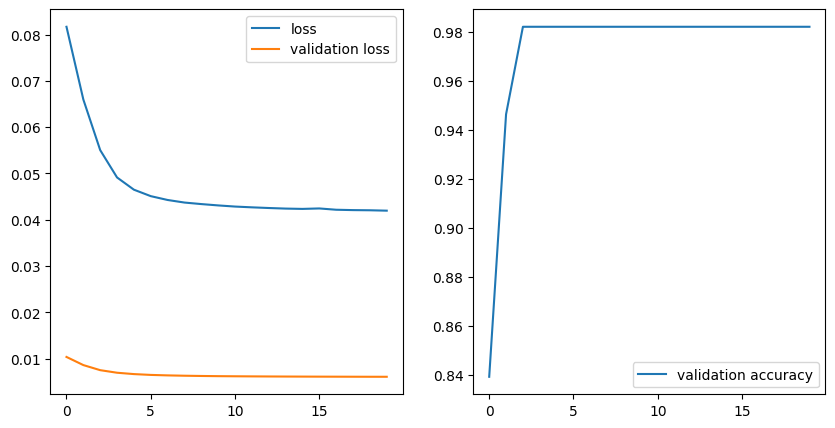

dropped: 26, test: loss: 0.34057924151420593, accuracy: 0.9767441749572754


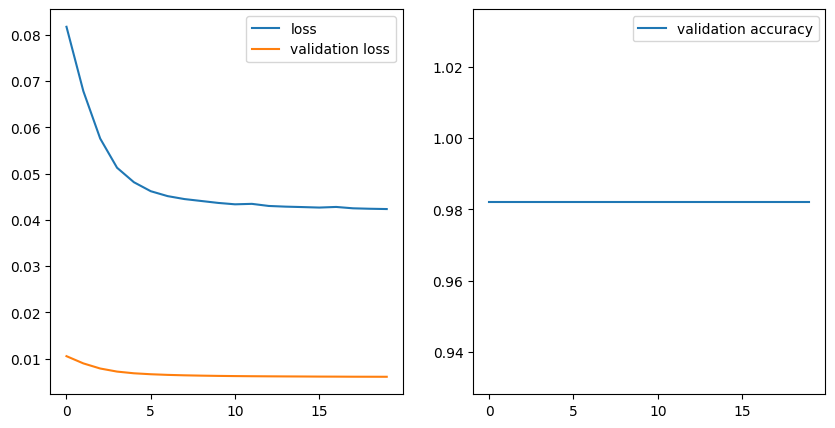

dropped: 27, test: loss: 0.34208807349205017, accuracy: 0.9825581312179565


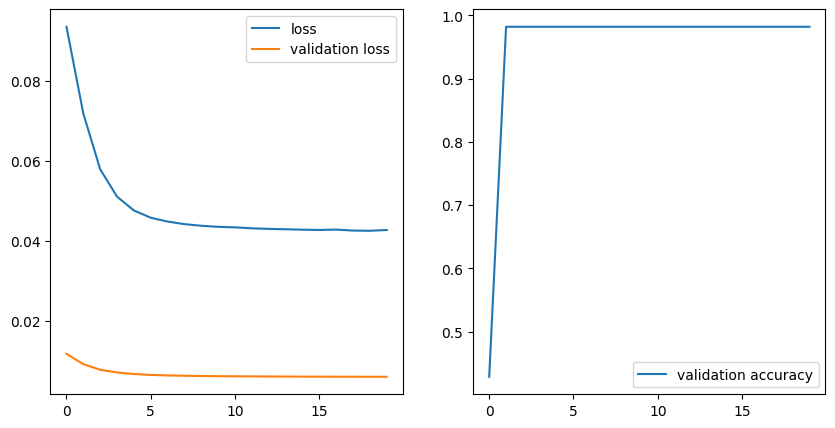

dropped: 28, test: loss: 0.3424307405948639, accuracy: 0.9825581312179565


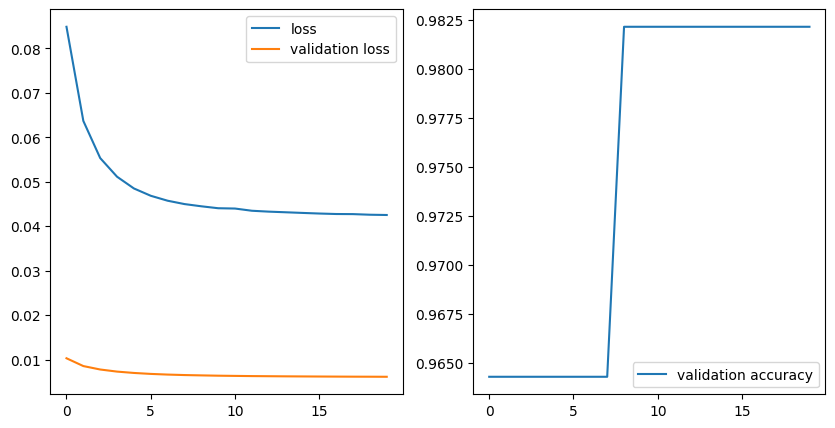

dropped: 29, test: loss: 0.3460831642150879, accuracy: 0.9651162624359131


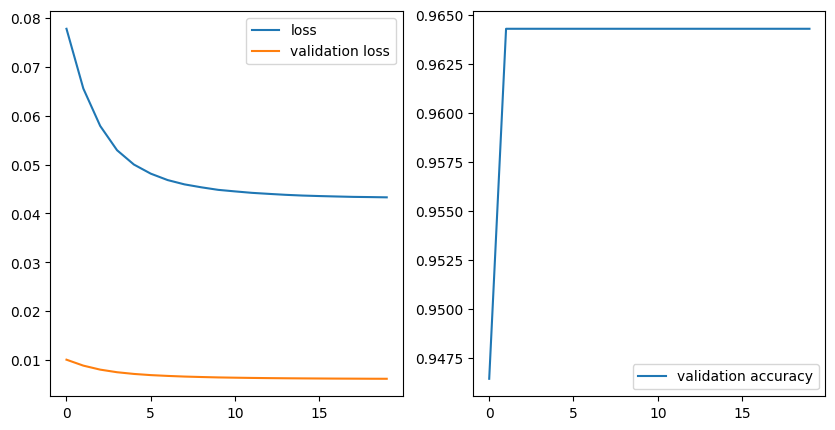

dropped: 30, test: loss: 0.34940826892852783, accuracy: 0.9651162624359131


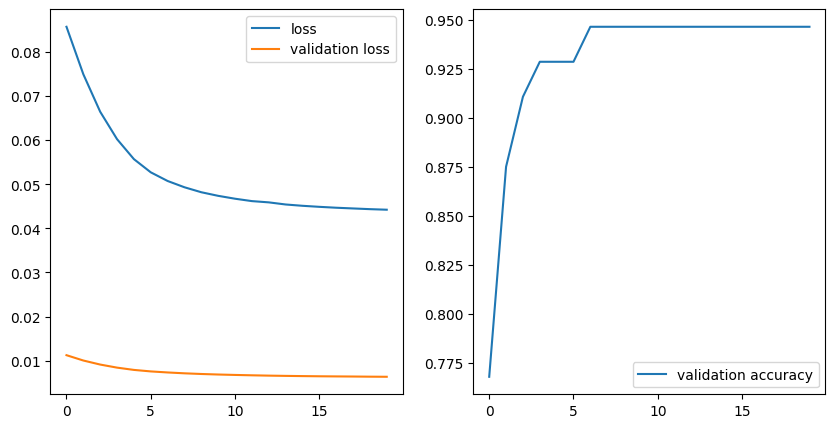

dropped: 31, test: loss: 0.35456550121307373, accuracy: 0.9651162624359131


In [232]:
# TODO: extraction to functions to accomodate other dataset+models?
hidden_size = 32
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: BreastCancerNN(x, (y, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = dgsm_remove_neurons(datasets, hidden_size, model_factory, optimizer_factory, criterion)

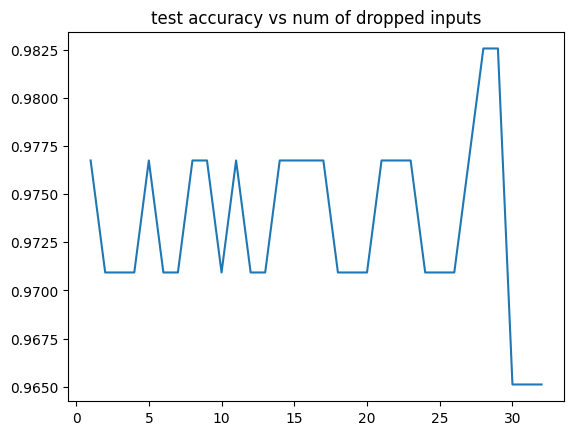

In [233]:
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped inputs")
plt.show()

In [234]:
pick_neurons_to_drop(26, hidden_size, dropped_neurons, best_model, models)

(BreastCancerNN(
   (layer1): Sequential(
     (0): Linear(in_features=8, out_features=6, bias=True)
     (1): ReLU()
   )
   (layer2): Sequential(
     (0): Linear(in_features=6, out_features=32, bias=True)
     (1): ReLU()
   )
   (out): Linear(in_features=32, out_features=2, bias=True)
   (softmax): Softmax(dim=None)
 ),
 {'train': <torch.utils.data.dataset.TensorDataset at 0x7846438202b0>,
  'valid': <torch.utils.data.dataset.TensorDataset at 0x784643821ea0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x784643821d20>})

## FAST

In [235]:
problem = analyze_fast(breast_cancer_headers)
show_stats(problem, mode = "ST")
datasets = breast_cancer_datasets.copy()
headers = breast_cancer_headers.copy()
model_factory = lambda headers : BreastCancerNN(len(headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Samples:
	30 parameters: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
	30720 samples
Outputs:
	2 outputs: ['Y1', 'Y2']
	30720 evaluations
Analysis:
Y1:
                          S1        ST   S1_conf   ST_conf
radius1             0.049094  0.101231  0.013248  0.041811
texture1            0.070615  0.131909  0.018621  0.040764
perimeter1          0.006452  0.022691  0.014541  0.039120
area1               0.104337  0.198272  0.015219  0.037867
smoothness1         0.029753  0.070335  0.013617  0.039929
compactness1        0.005600  0.021398  0.012919  0.036275
concavity1          0.083178  0.166324  0.01

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


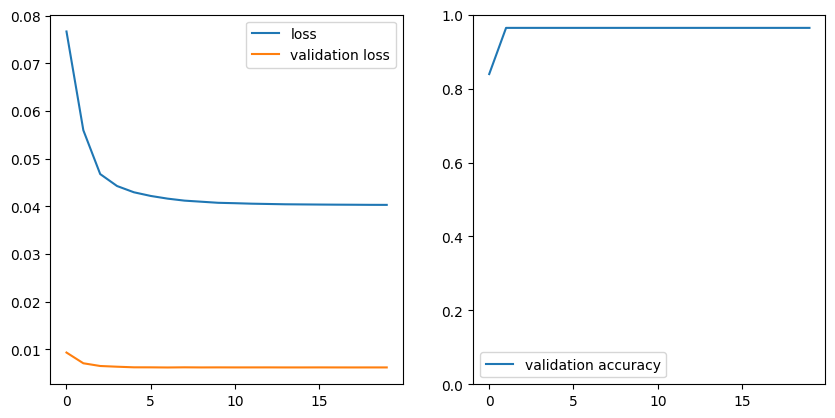

Test: loss: 0.34148767590522766, accuracy: 0.9709302186965942
dropping feature: (28, 'symmetry3')


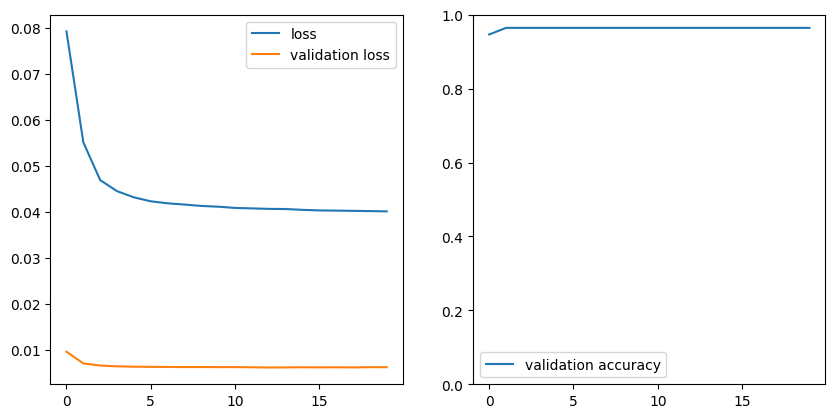

Test: loss: 0.3476479947566986, accuracy: 0.9593023061752319
dropping feature: (5, 'compactness1')


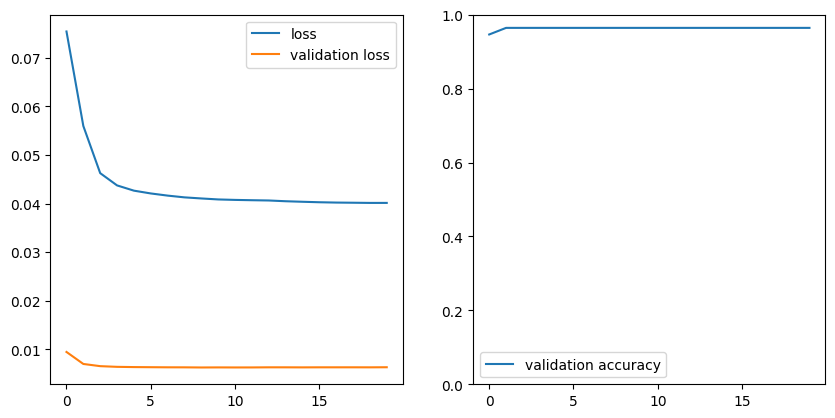

Test: loss: 0.3483821153640747, accuracy: 0.9593023061752319
dropping feature: (17, 'symmetry2')


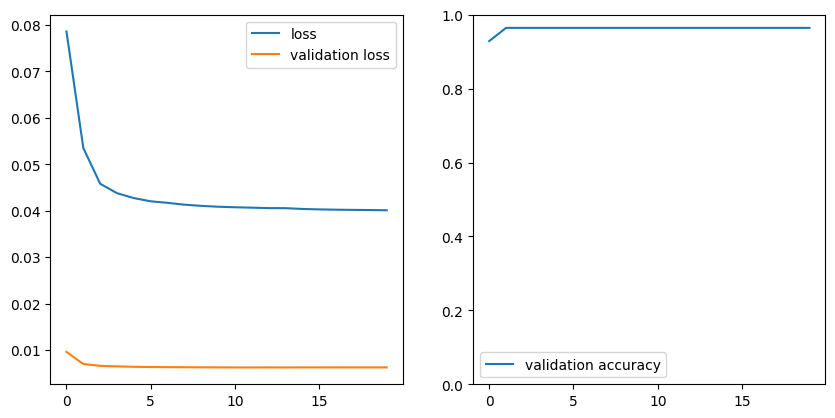

Test: loss: 0.3456268012523651, accuracy: 0.9651162624359131
dropping feature: (4, 'smoothness1')


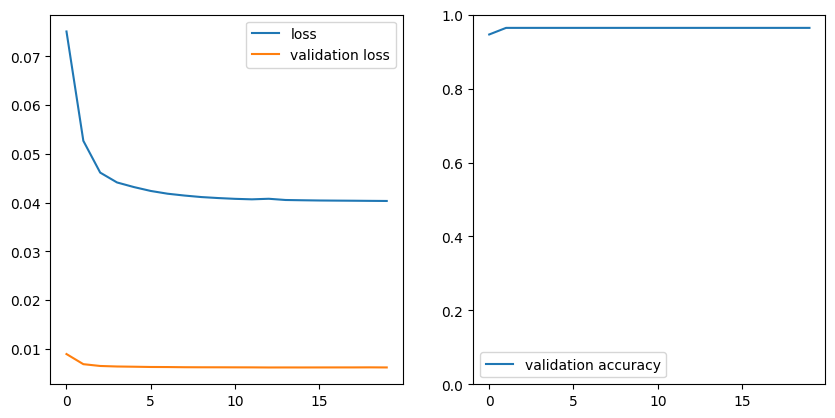

Test: loss: 0.3399730324745178, accuracy: 0.9767441749572754
dropping feature: (9, 'texture2')


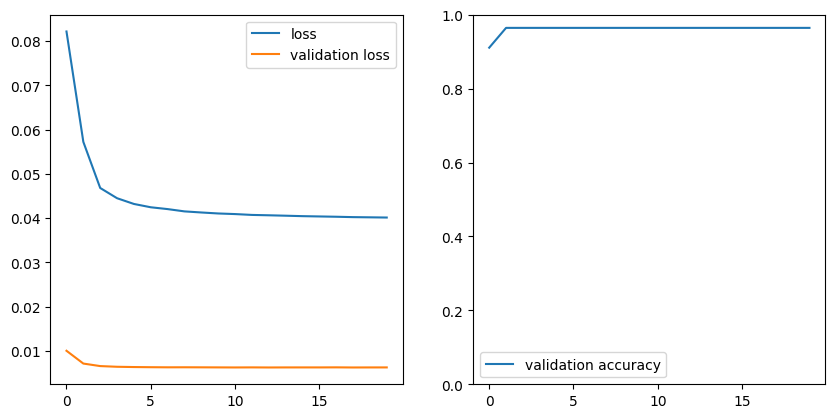

Test: loss: 0.3421279191970825, accuracy: 0.9709302186965942
dropping feature: (2, 'perimeter1')


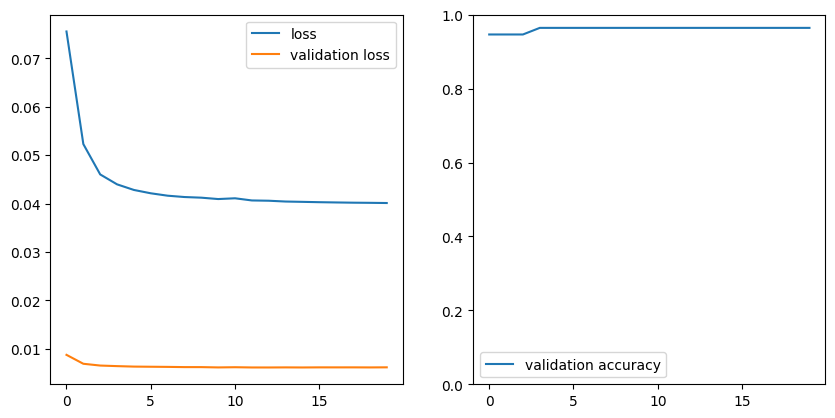

Test: loss: 0.3416701555252075, accuracy: 0.9709302186965942
dropping feature: (20, 'compactness3')


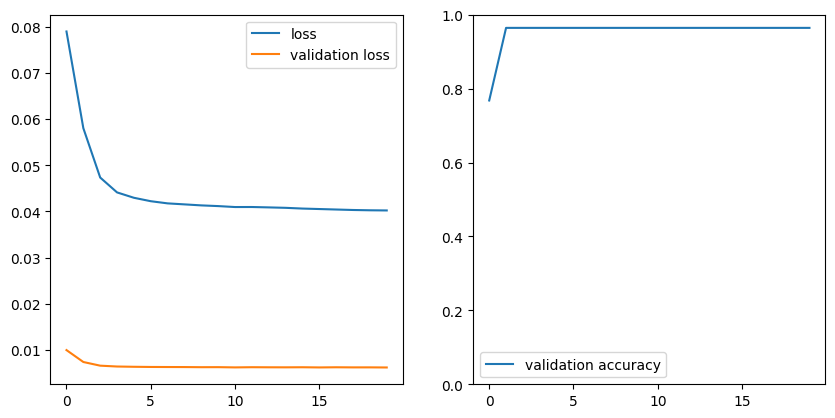

Test: loss: 0.342662513256073, accuracy: 0.9651162624359131
dropping feature: (21, 'concave_points3')


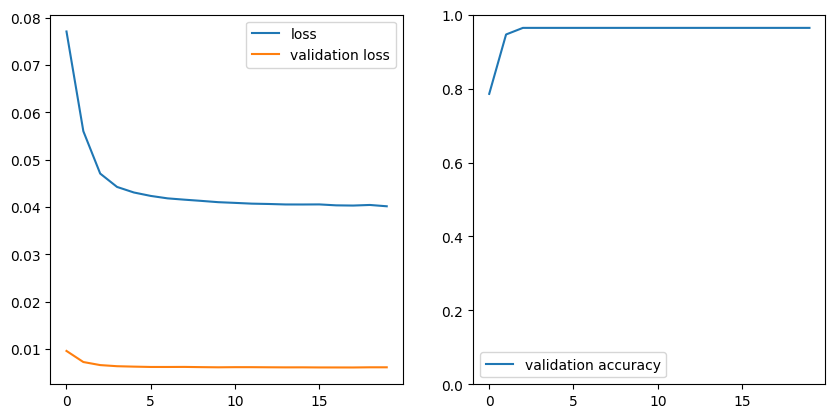

Test: loss: 0.35058510303497314, accuracy: 0.9593023061752319
dropping feature: (2, 'area1')


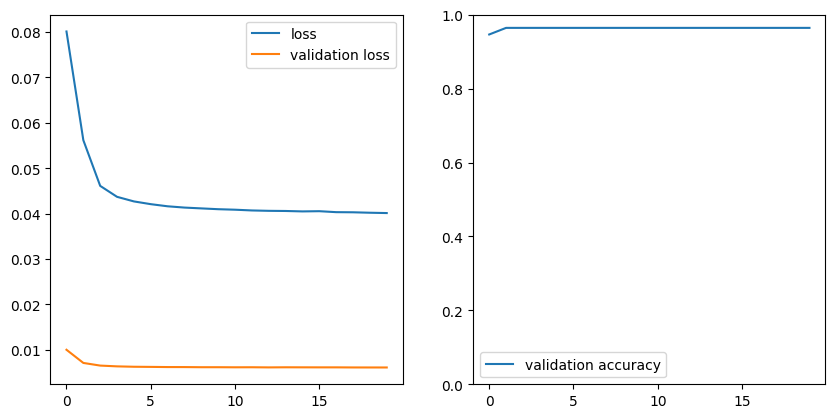

Test: loss: 0.3469245731830597, accuracy: 0.9651162624359131
dropping feature: (20, 'fractal_dimension3')


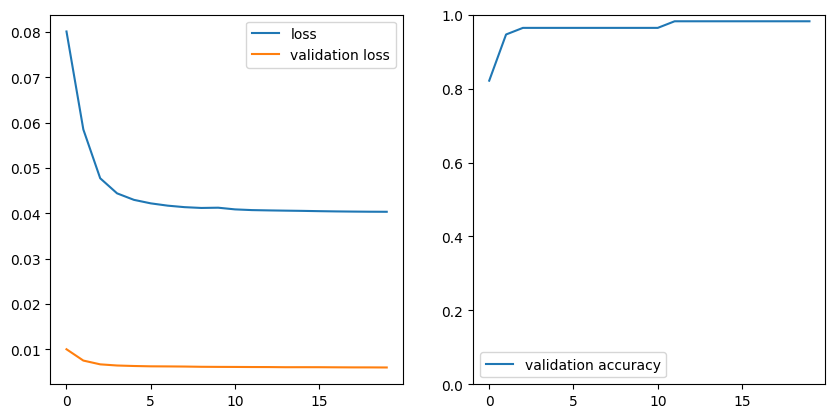

Test: loss: 0.34229838848114014, accuracy: 0.9709302186965942
dropping feature: (4, 'symmetry1')


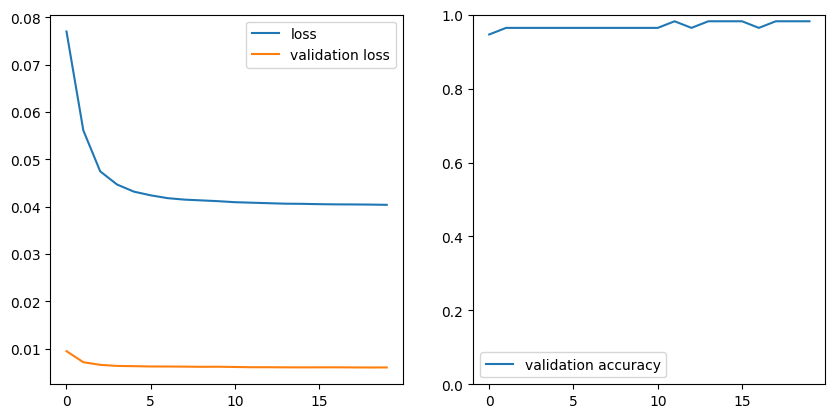

Test: loss: 0.3449798822402954, accuracy: 0.9651162624359131
dropping feature: (4, 'fractal_dimension1')


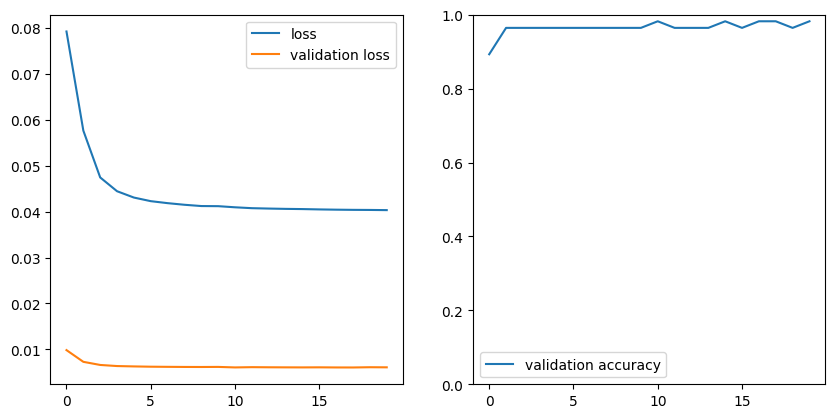

Test: loss: 0.3441973328590393, accuracy: 0.9651162624359131
dropping feature: (4, 'radius2')


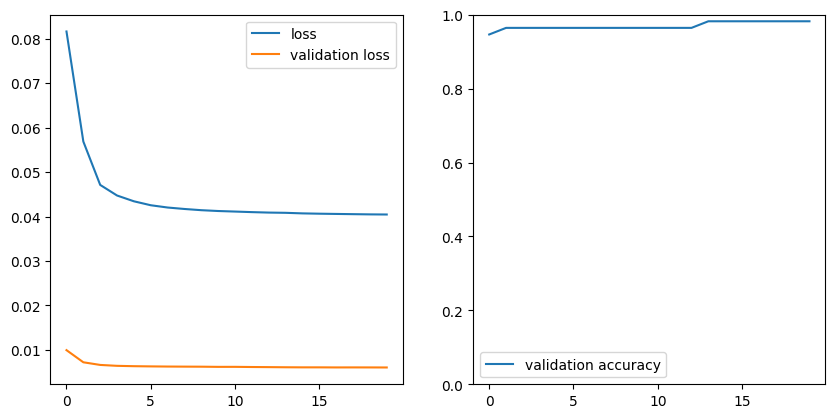

Test: loss: 0.34366366267204285, accuracy: 0.9709302186965942
dropping feature: (2, 'concavity1')


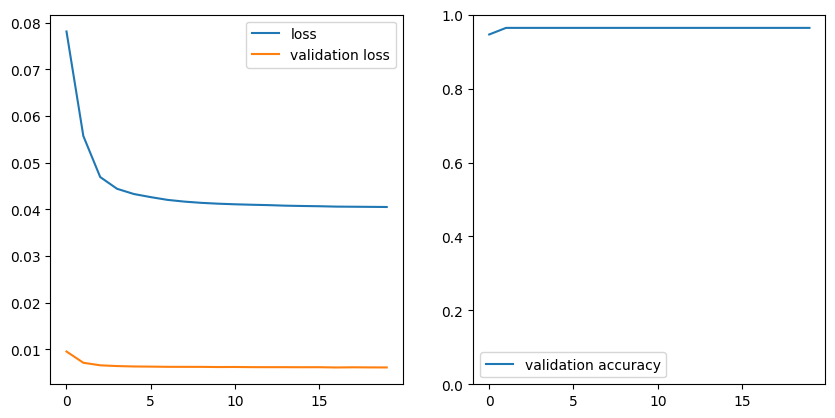

Test: loss: 0.34101322293281555, accuracy: 0.9709302186965942
dropping feature: (5, 'smoothness2')


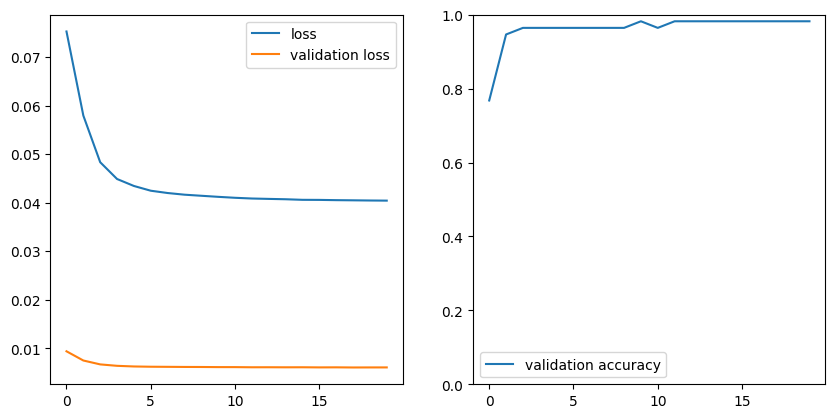

Test: loss: 0.34063398838043213, accuracy: 0.9767441749572754
dropping feature: (5, 'compactness2')


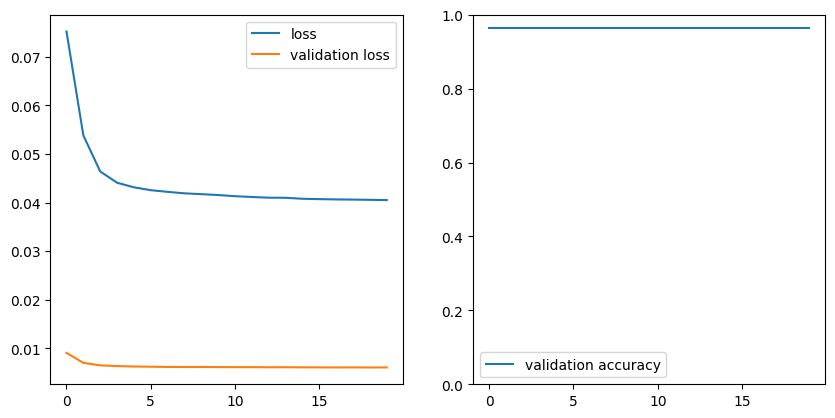

Test: loss: 0.33512476086616516, accuracy: 0.9767441749572754
dropping feature: (5, 'concavity2')


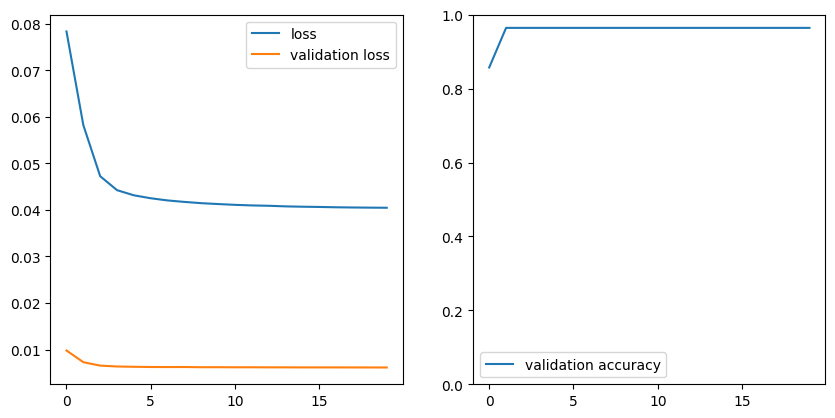

Test: loss: 0.33604151010513306, accuracy: 0.9767441749572754
dropping feature: (5, 'concave_points2')


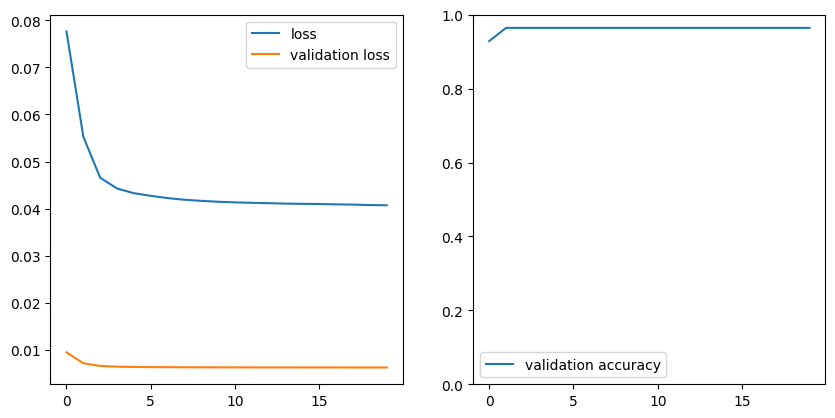

Test: loss: 0.3348131477832794, accuracy: 0.9767441749572754
dropping feature: (5, 'fractal_dimension2')


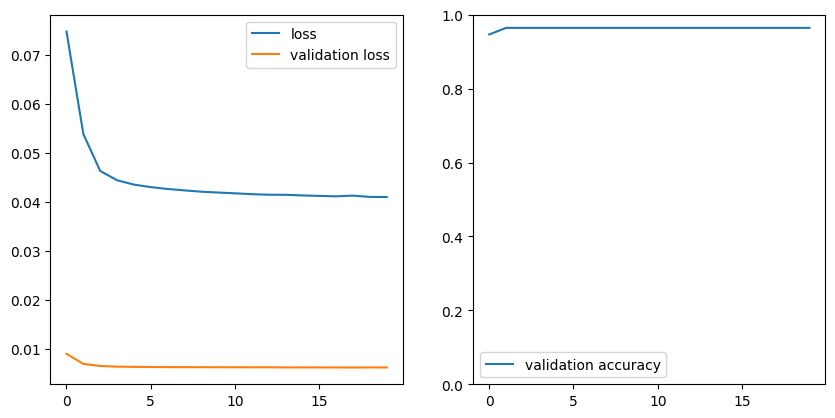

Test: loss: 0.3324992060661316, accuracy: 0.9825581312179565
dropping feature: (3, 'perimeter2')


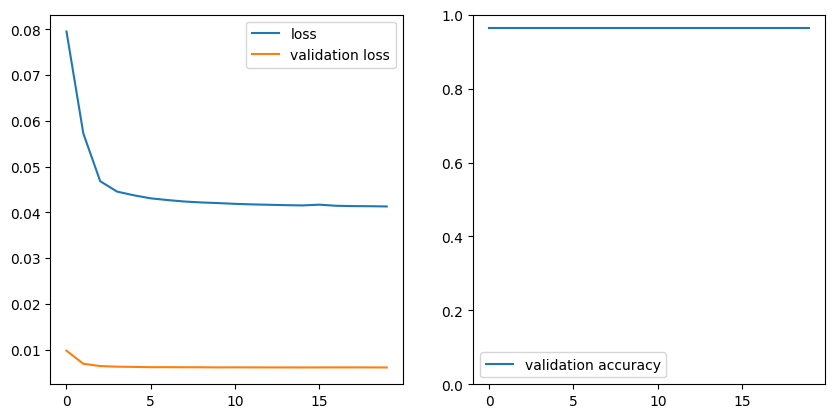

Test: loss: 0.33346396684646606, accuracy: 0.9825581312179565
dropping feature: (2, 'concave_points1')


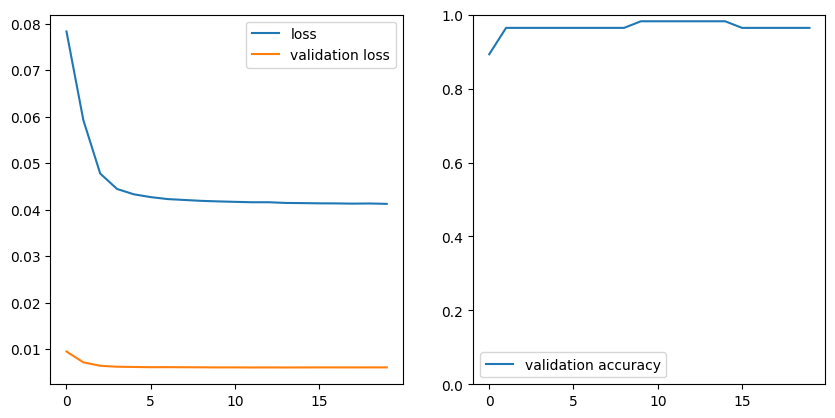

Test: loss: 0.33522966504096985, accuracy: 0.9825581312179565
dropping feature: (4, 'texture3')


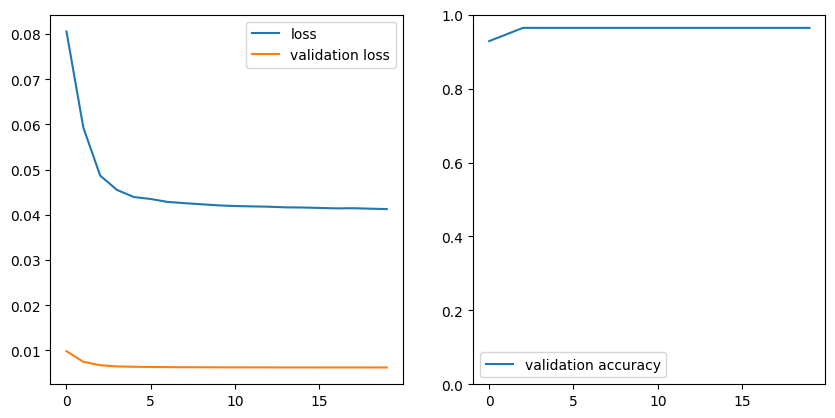

Test: loss: 0.33531925082206726, accuracy: 0.9767441749572754
dropping feature: (4, 'perimeter3')


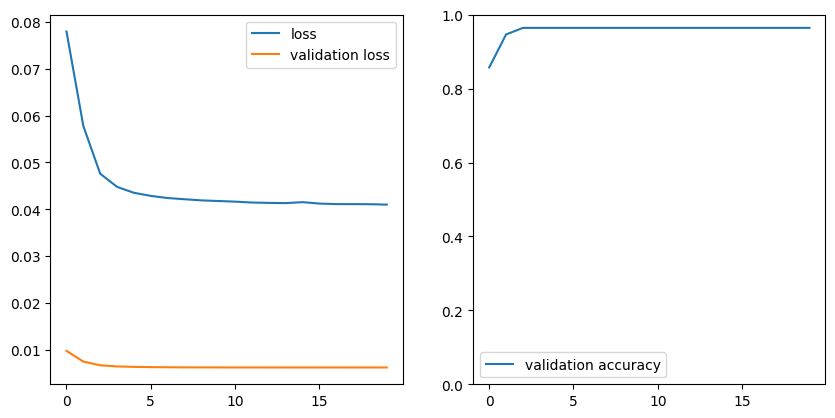

Test: loss: 0.3356125056743622, accuracy: 0.9767441749572754
dropping feature: (2, 'area2')


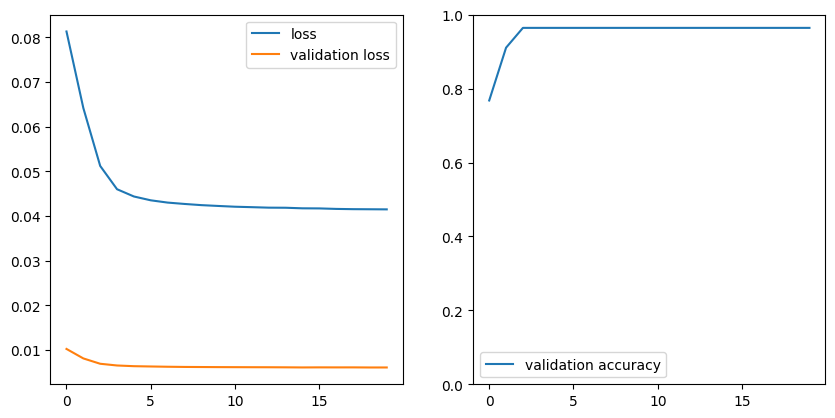

Test: loss: 0.33862054347991943, accuracy: 0.9767441749572754
dropping feature: (4, 'smoothness3')


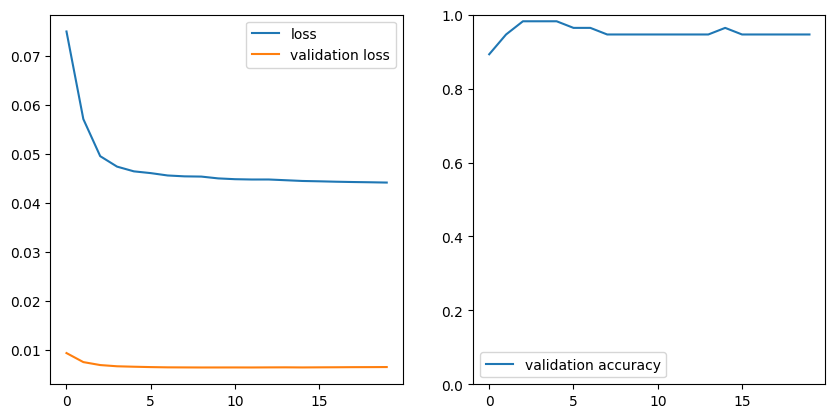

Test: loss: 0.3469102382659912, accuracy: 0.9709302186965942
dropping feature: (4, 'concavity3')


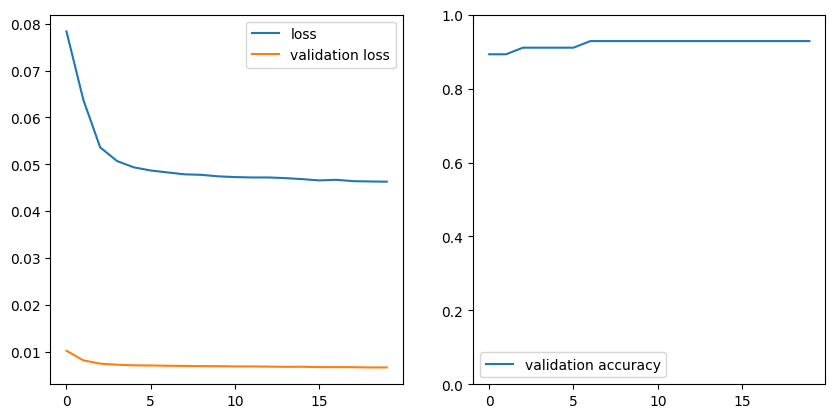

Test: loss: 0.3962683081626892, accuracy: 0.9069767594337463
dropping feature: (0, 'radius1')


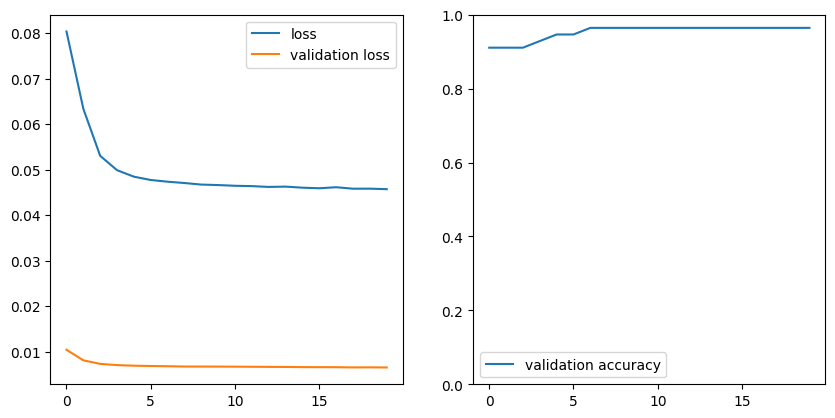

Test: loss: 0.38571518659591675, accuracy: 0.930232584476471
dropping feature: (0, 'texture1')


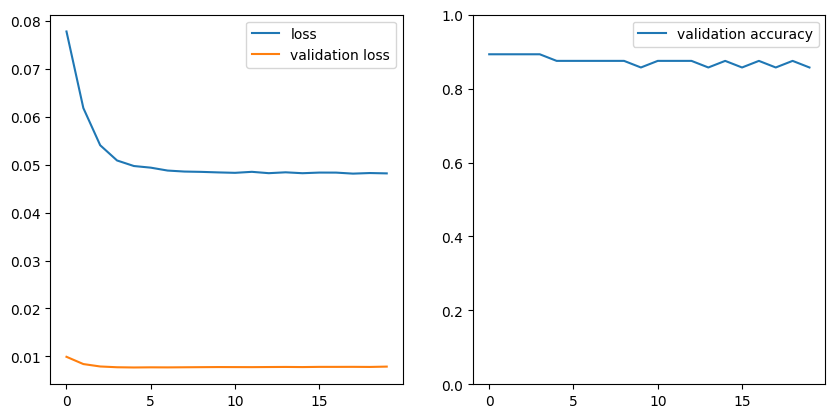

Test: loss: 0.40359461307525635, accuracy: 0.9069767594337463
dropping feature: (1, 'area3')


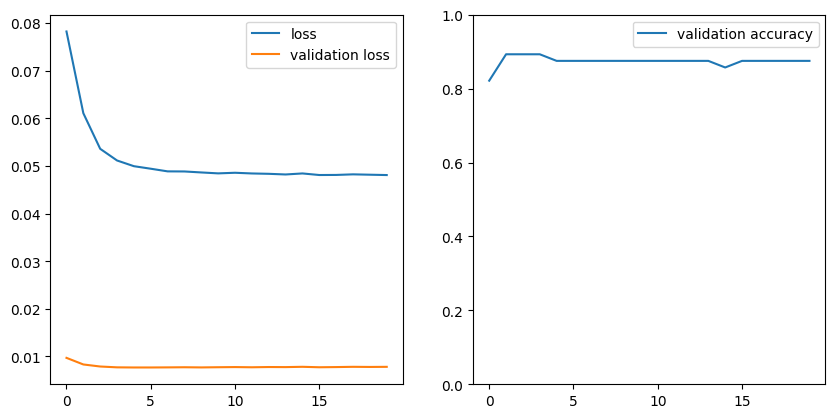

Test: loss: 0.4058571755886078, accuracy: 0.9127907156944275


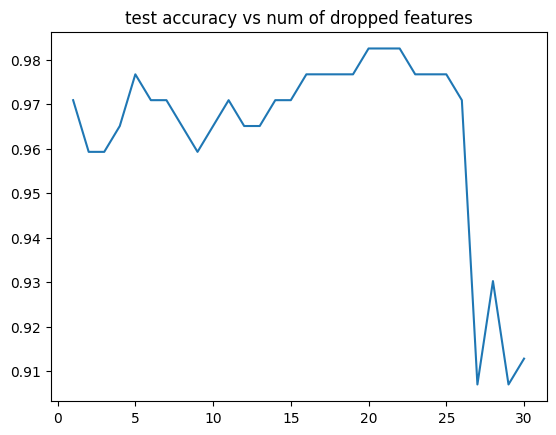

In [236]:
test_accs, dropped_headers, models = fast_remove_headers(datasets, headers, model_factory, optimizer_factory ,criterion)
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped features")
plt.show()

In [237]:
reduced_headers = breast_cancer_headers.copy()
datasets = breast_cancer_datasets
num_drop_features = 21
best_model, reduced_datasets = pick_features_to_drop(reduced_headers, dropped_headers, models, datasets, num_drop_features)

[9] features left: ['radius1', 'texture1', 'area2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'concavity3']


In [238]:
layer: nn.Module = best_model.layer1
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

In [239]:
# not needed in this model, maybe usefull in bigger one to save some traning time? to be tested
# will need acrobatics for sure (tweaking state_dict)
base_model = BreastCancerNN(len(breast_cancer_headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_pre_train(base_model, criterion, optimizer_factory, datasets)

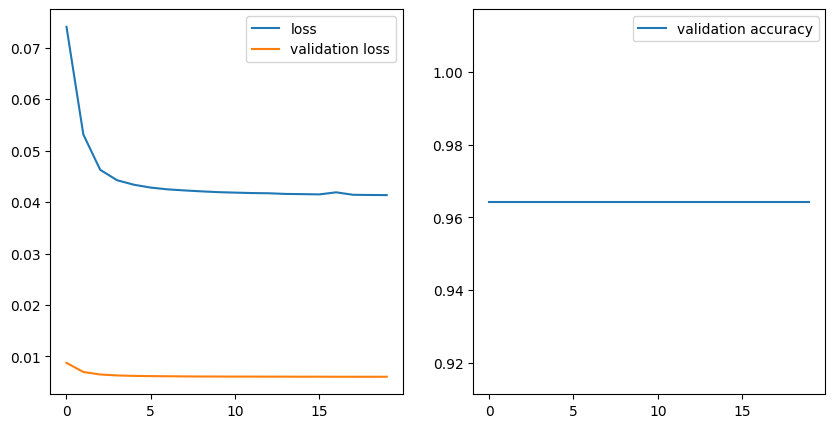

dropped: 0, test: loss: 0.3366217613220215, accuracy: 0.9825581312179565


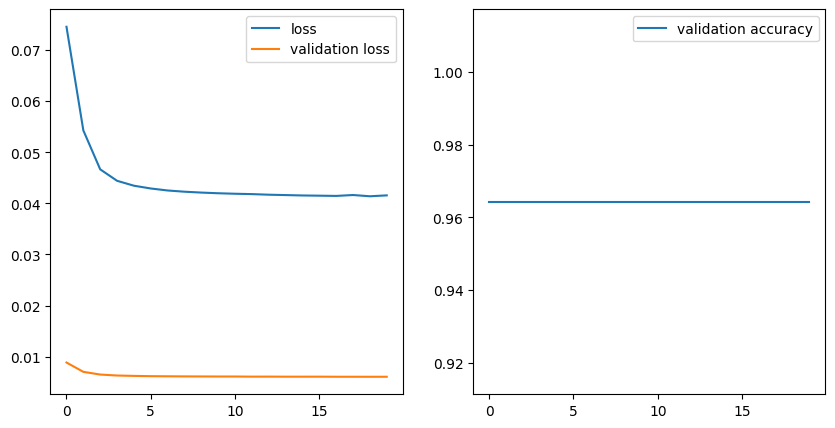

dropped: 1, test: loss: 0.3363381624221802, accuracy: 0.9825581312179565


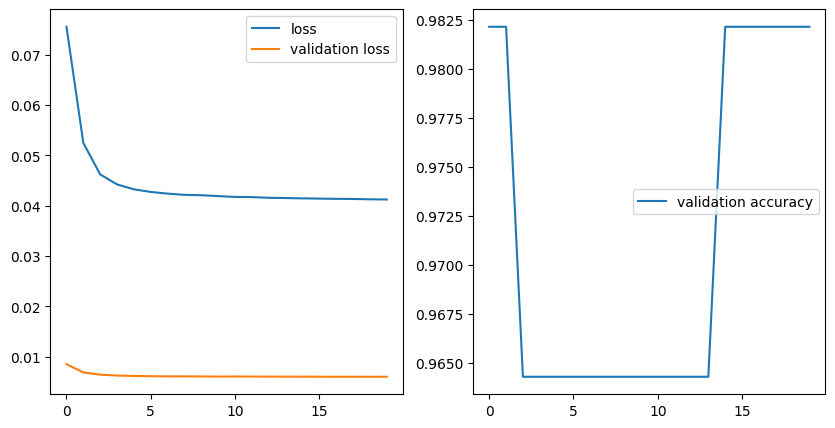

dropped: 2, test: loss: 0.33540070056915283, accuracy: 0.9825581312179565


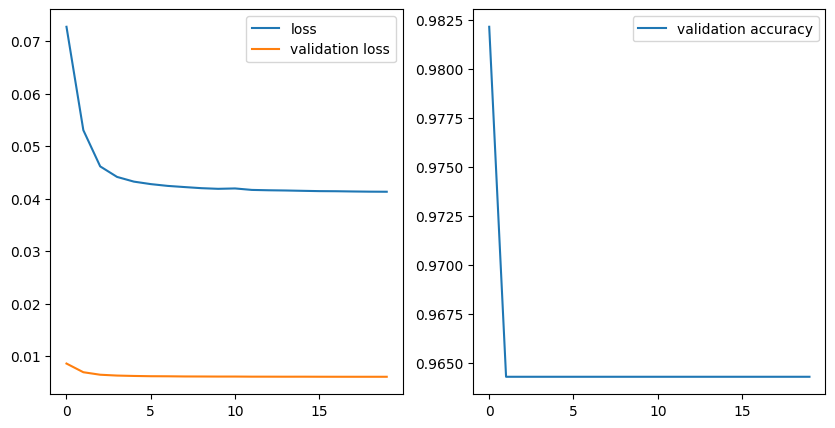

dropped: 3, test: loss: 0.33557364344596863, accuracy: 0.9825581312179565


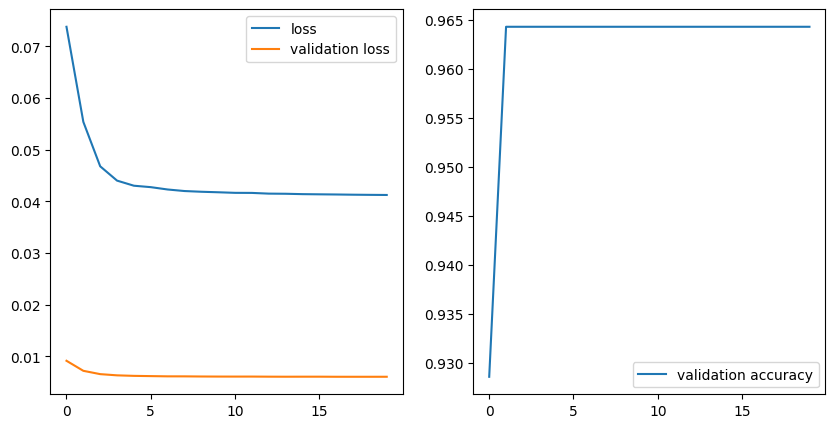

dropped: 4, test: loss: 0.33577975630760193, accuracy: 0.9825581312179565


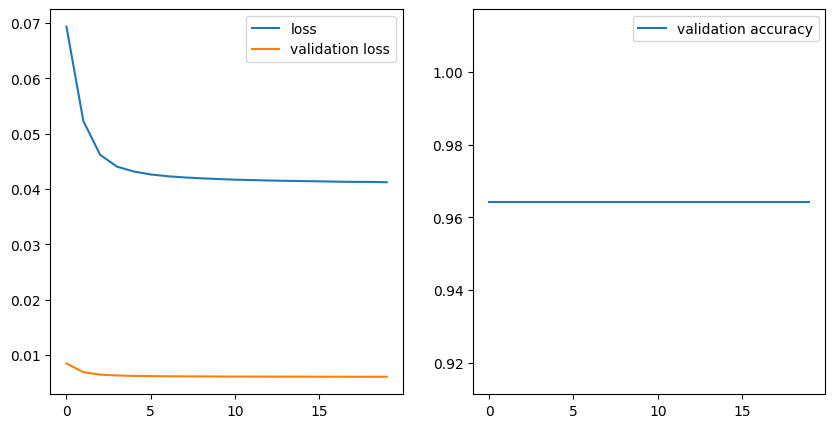

dropped: 5, test: loss: 0.3348945677280426, accuracy: 0.9825581312179565


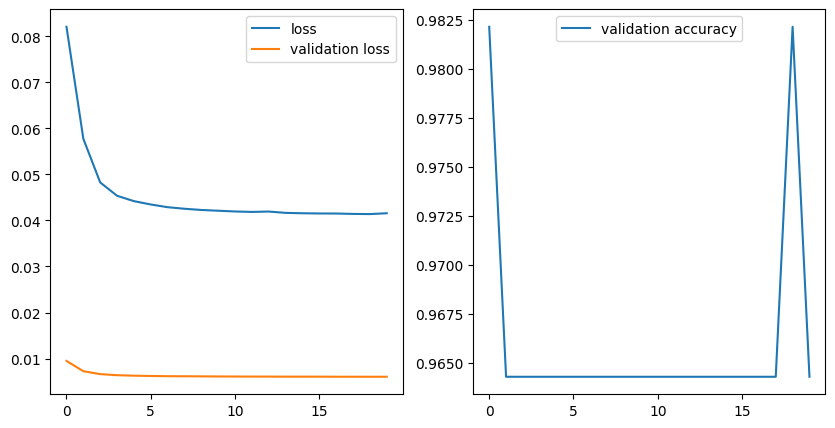

dropped: 6, test: loss: 0.33600255846977234, accuracy: 0.9825581312179565


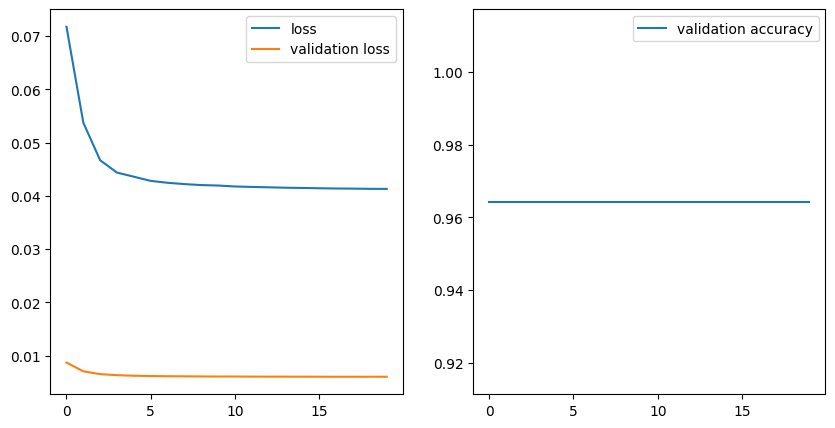

dropped: 7, test: loss: 0.3355944752693176, accuracy: 0.9825581312179565


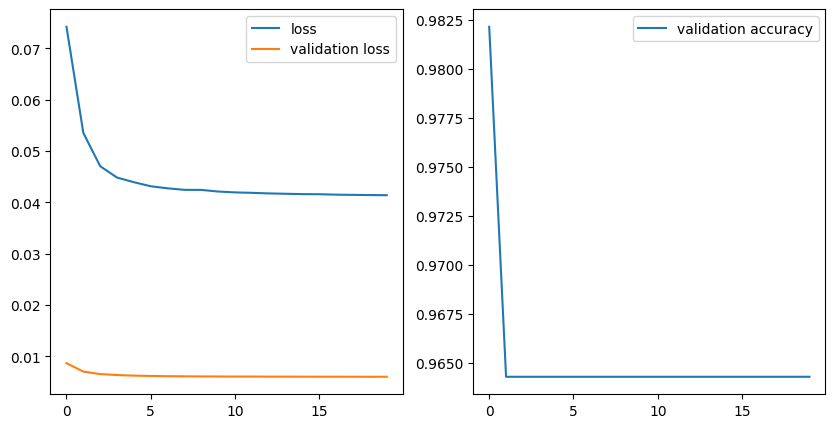

dropped: 8, test: loss: 0.33590638637542725, accuracy: 0.9825581312179565


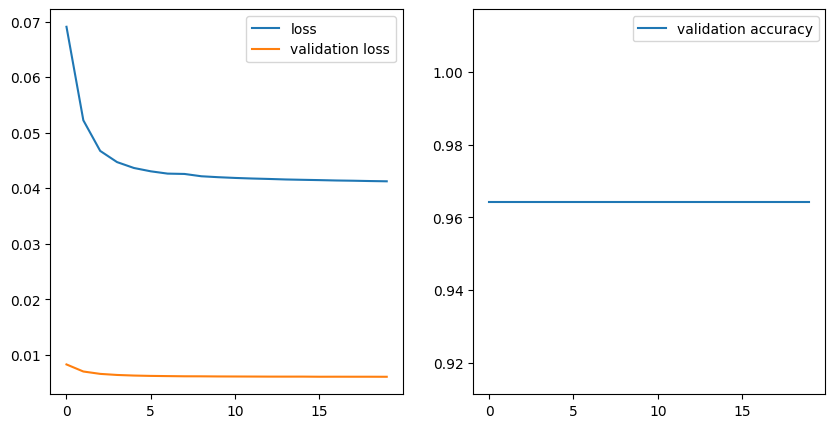

dropped: 9, test: loss: 0.3355138599872589, accuracy: 0.9825581312179565


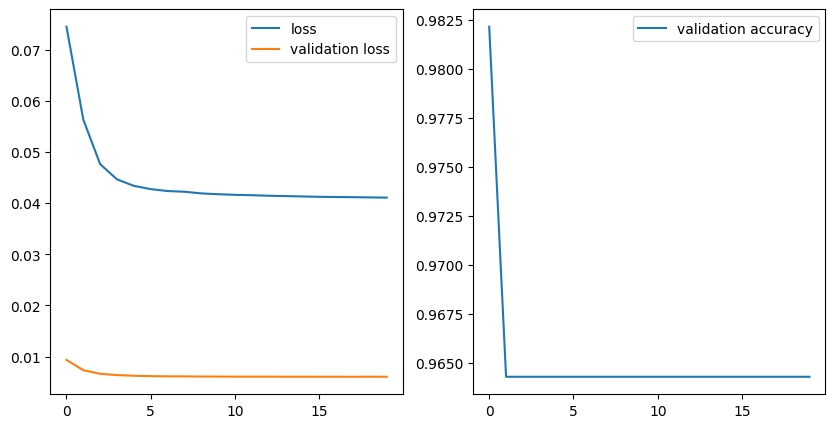

dropped: 10, test: loss: 0.33475369215011597, accuracy: 0.9825581312179565


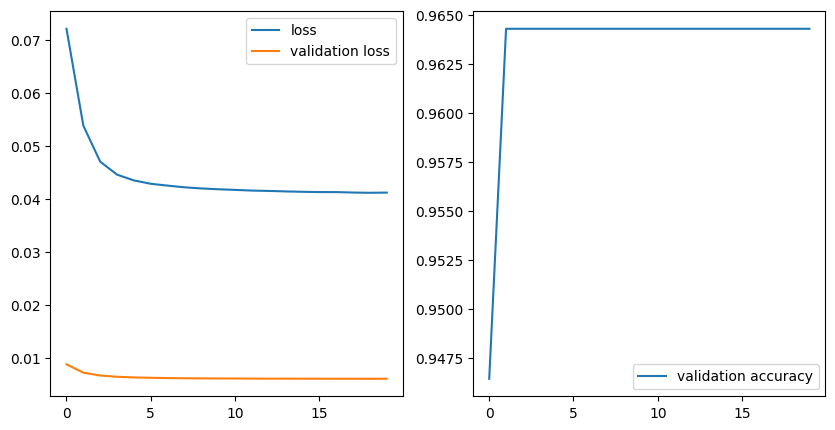

dropped: 11, test: loss: 0.3349631428718567, accuracy: 0.9825581312179565


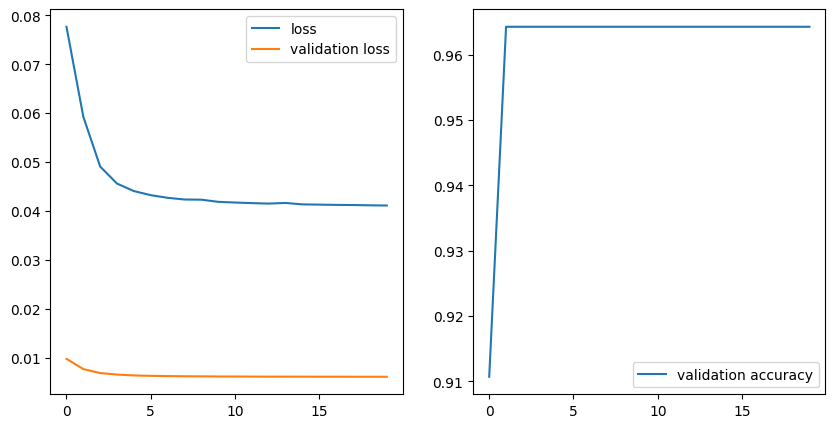

dropped: 12, test: loss: 0.3348318636417389, accuracy: 0.9825581312179565


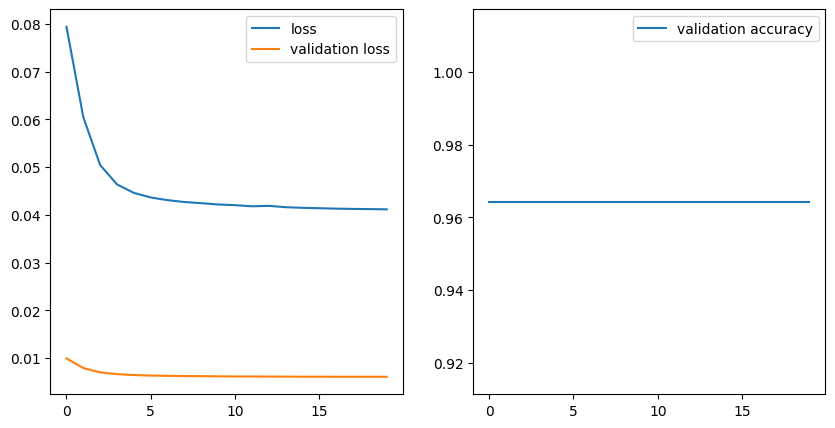

dropped: 13, test: loss: 0.33533814549446106, accuracy: 0.9825581312179565


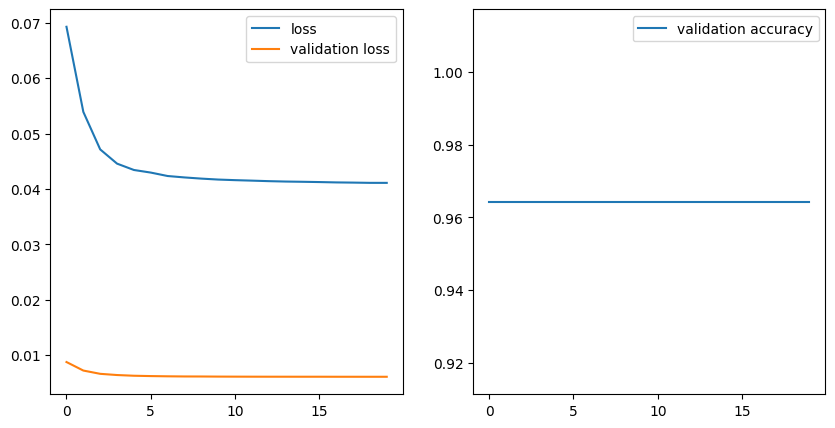

dropped: 14, test: loss: 0.334490567445755, accuracy: 0.9825581312179565


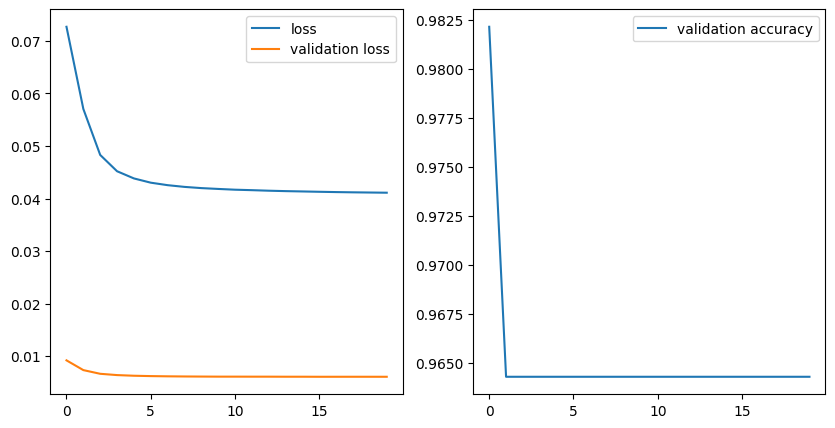

dropped: 15, test: loss: 0.334784597158432, accuracy: 0.9825581312179565


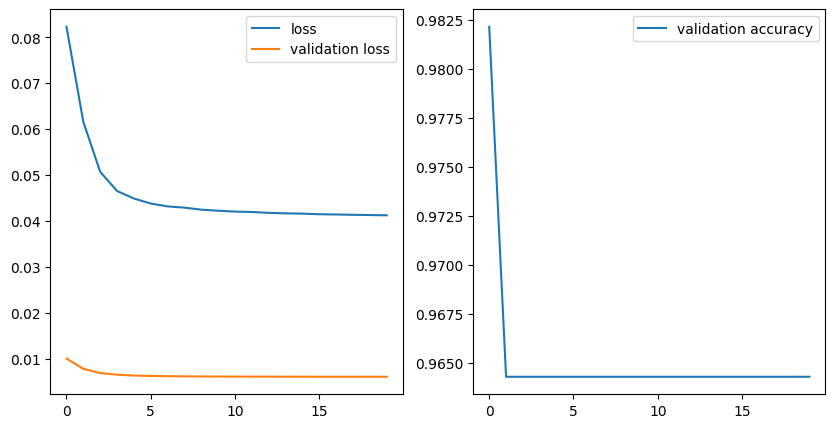

dropped: 16, test: loss: 0.3354591131210327, accuracy: 0.9825581312179565


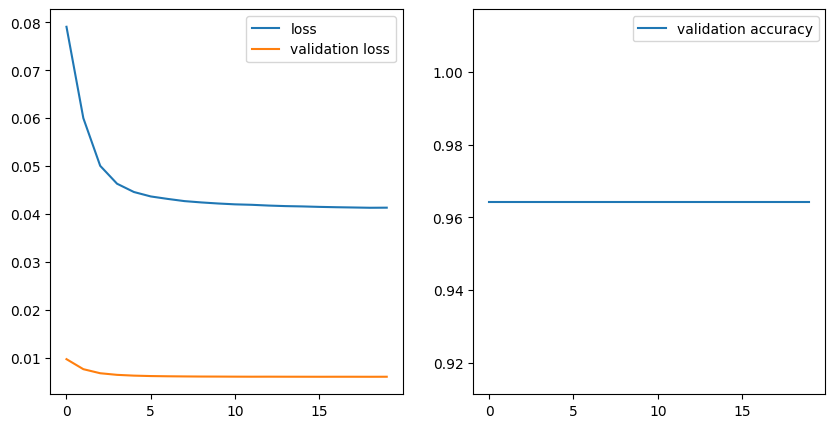

dropped: 17, test: loss: 0.3359697163105011, accuracy: 0.9825581312179565


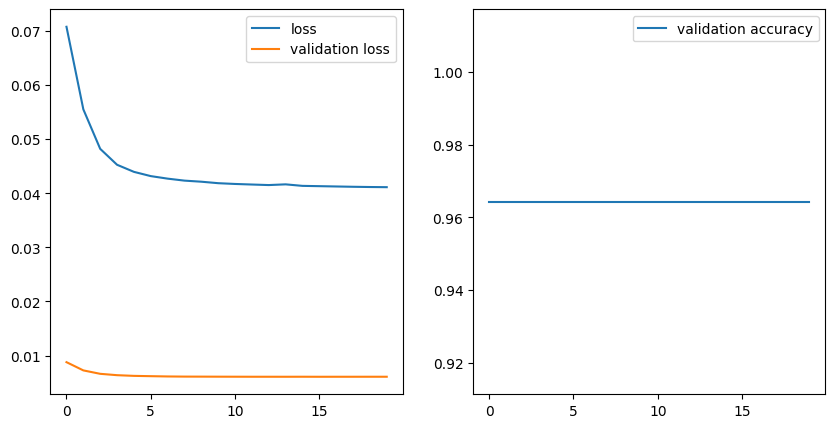

dropped: 18, test: loss: 0.33526816964149475, accuracy: 0.9825581312179565


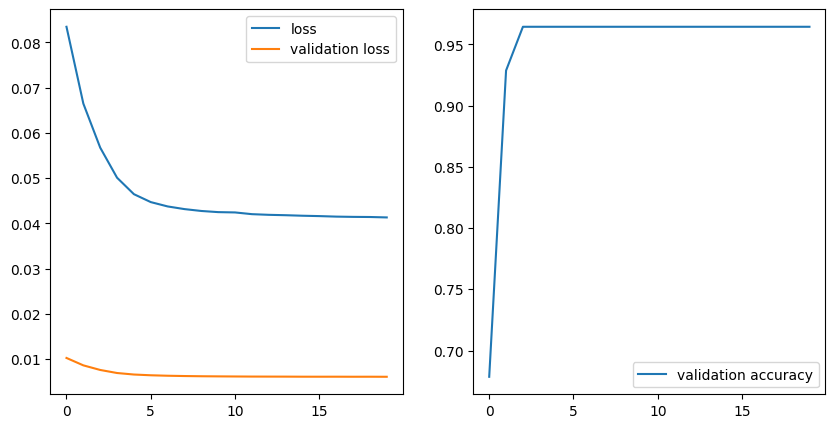

dropped: 19, test: loss: 0.3364447355270386, accuracy: 0.9825581312179565


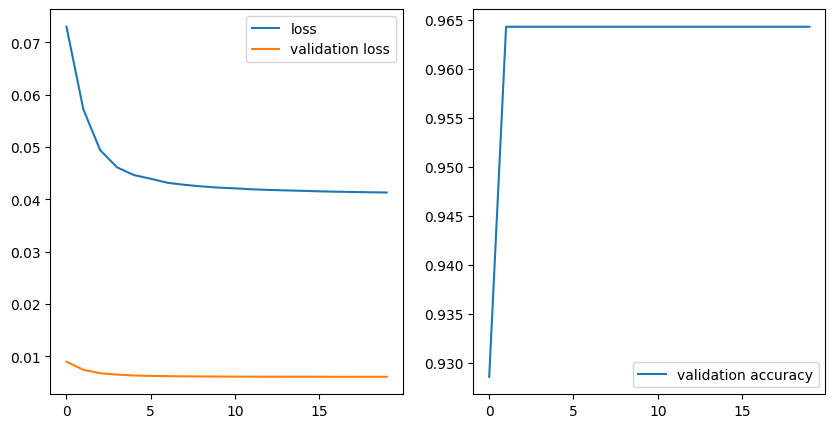

dropped: 20, test: loss: 0.3360954523086548, accuracy: 0.9825581312179565


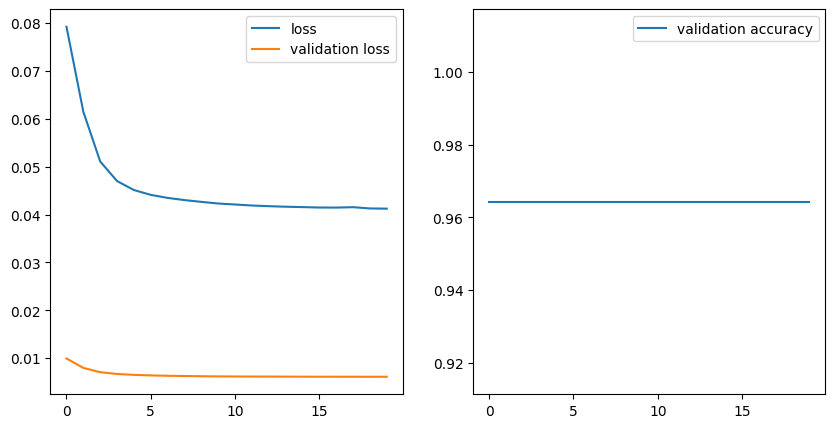

dropped: 21, test: loss: 0.3360651135444641, accuracy: 0.9825581312179565


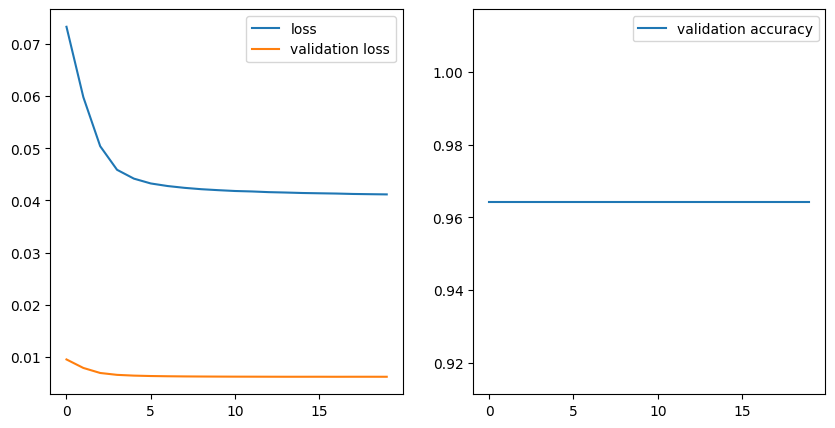

dropped: 22, test: loss: 0.3353289067745209, accuracy: 0.9825581312179565


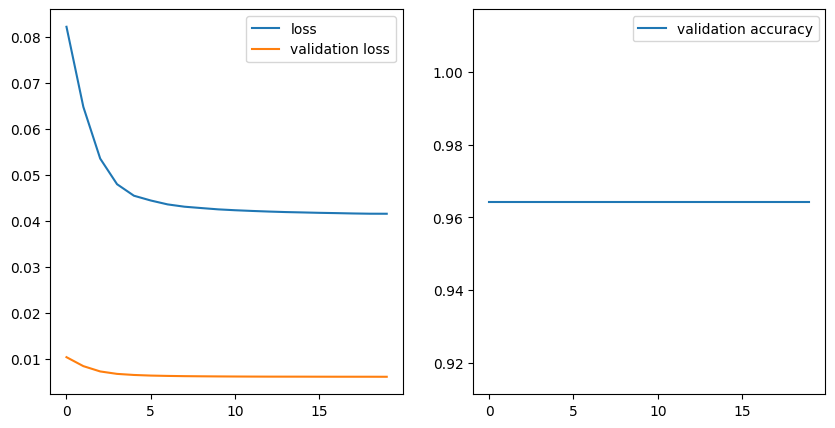

dropped: 23, test: loss: 0.3367639482021332, accuracy: 0.9825581312179565


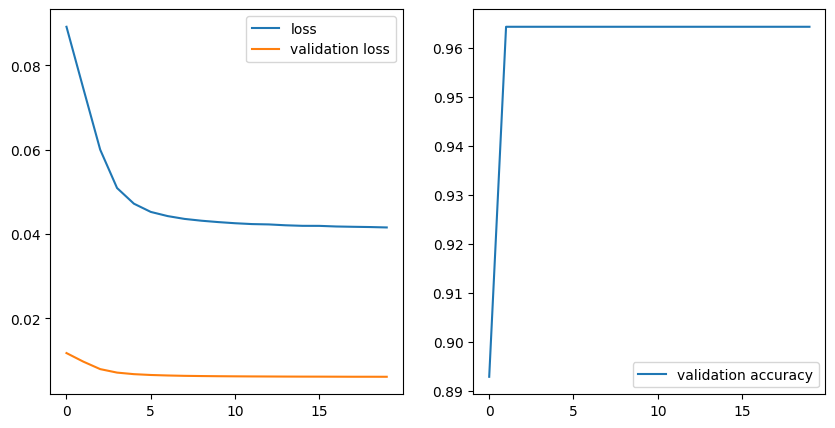

dropped: 24, test: loss: 0.33744359016418457, accuracy: 0.9825581312179565


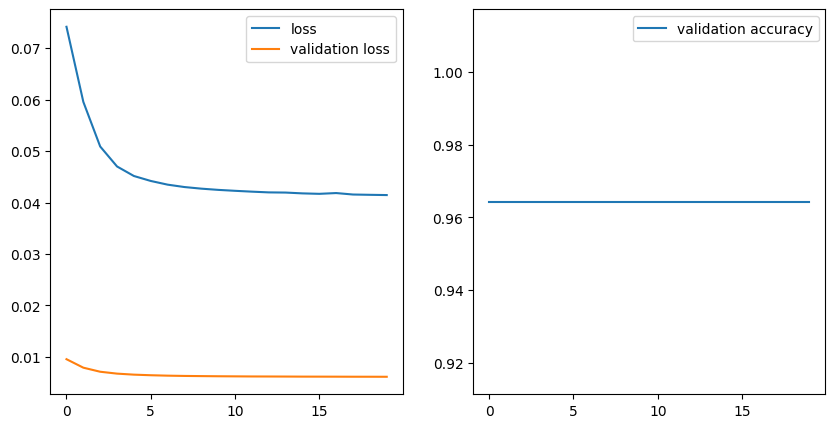

dropped: 25, test: loss: 0.33774712681770325, accuracy: 0.9825581312179565


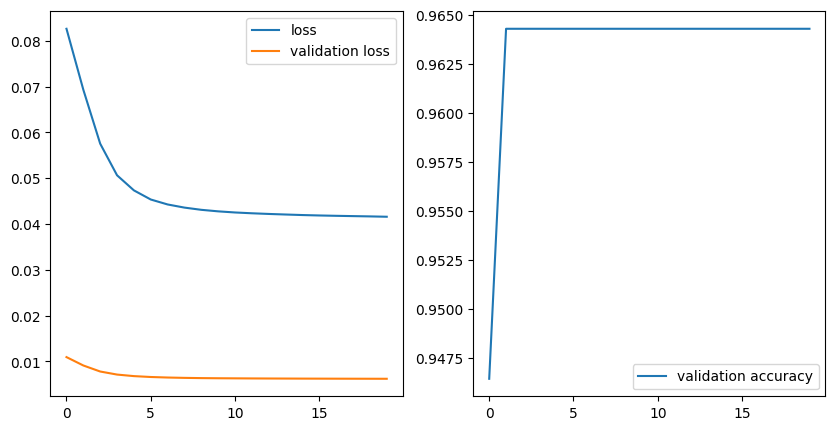

dropped: 26, test: loss: 0.3399074375629425, accuracy: 0.9709302186965942


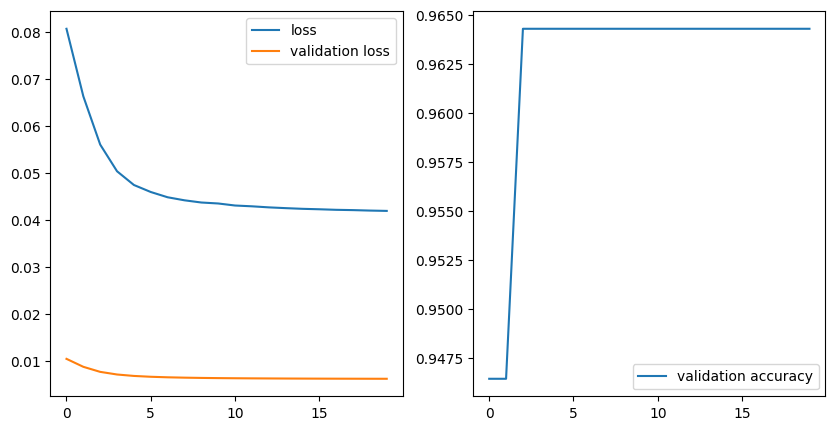

dropped: 27, test: loss: 0.3414041996002197, accuracy: 0.9767441749572754


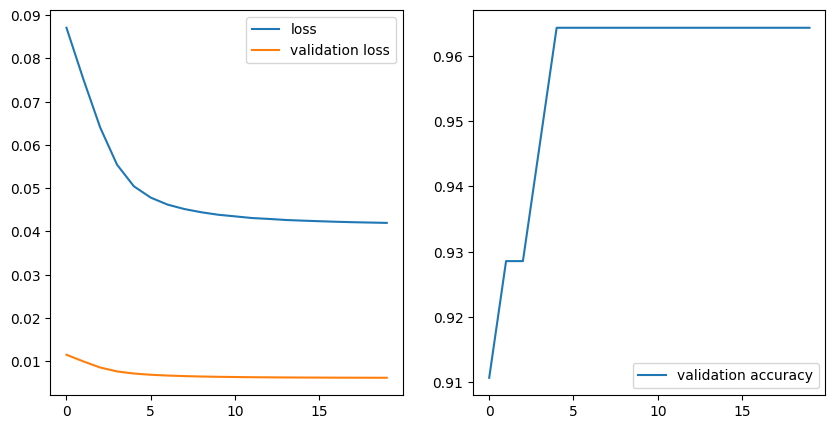

dropped: 28, test: loss: 0.3433670997619629, accuracy: 0.9767441749572754


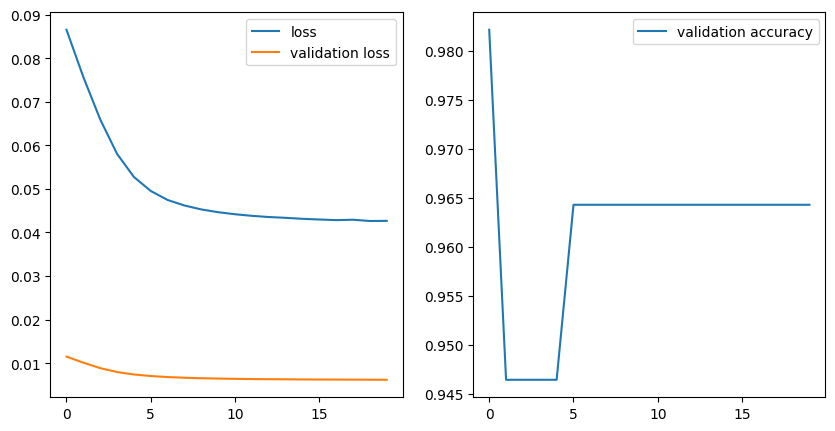

dropped: 29, test: loss: 0.3431805968284607, accuracy: 0.9825581312179565


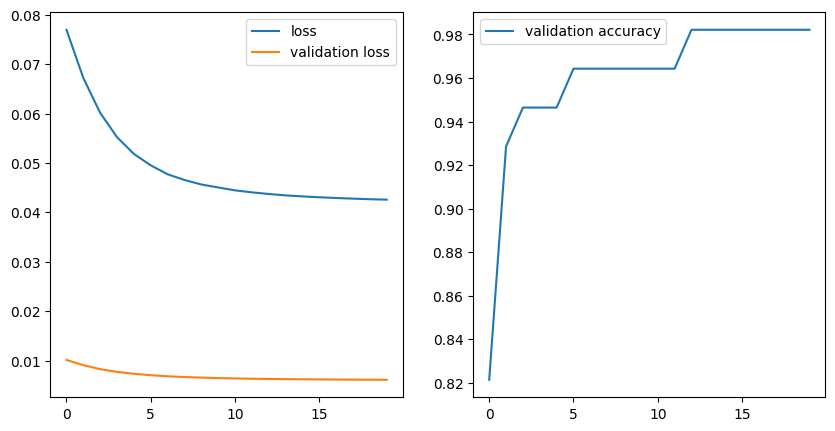

dropped: 30, test: loss: 0.3449694514274597, accuracy: 0.9825581312179565


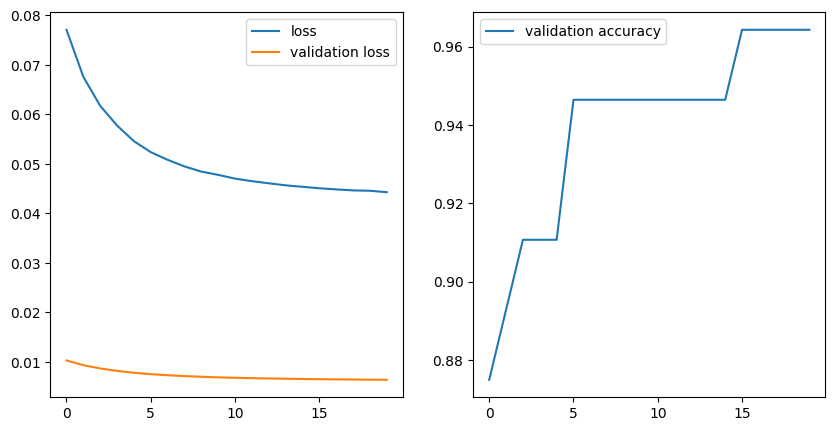

dropped: 31, test: loss: 0.35561224818229675, accuracy: 0.9593023061752319


In [240]:
# Layer 1
hidden_size = 32
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: BreastCancerNN(x, (y, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = fast_remove_neurons(datasets, hidden_size, model_factory, optimizer_factory, criterion)

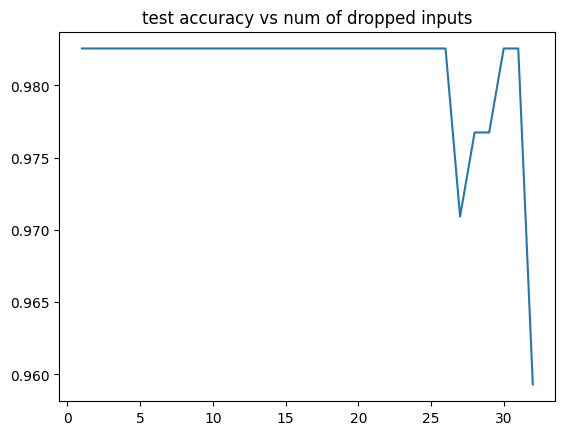

In [241]:
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped inputs")
plt.show()

In [242]:
num_drop_neurons = 28
best_model_layer1, reduced_datasets_neurons_layer1 = pick_neurons_to_drop(num_drop_neurons, hidden_size, dropped_neurons, best_model, models)

In [243]:
print(best_model_layer1)

BreastCancerNN(
  (layer1): Sequential(
    (0): Linear(in_features=9, out_features=4, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=32, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)


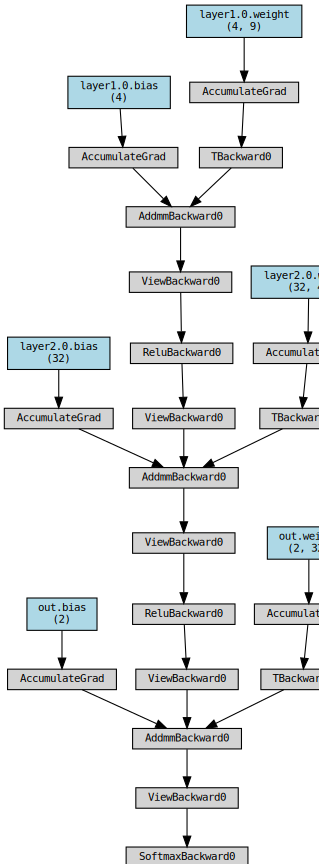

In [244]:
y = best_model_layer1(reduced_datasets["test"][0][0]);
make_dot(y.mean(), params=dict(best_model_layer1.named_parameters()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


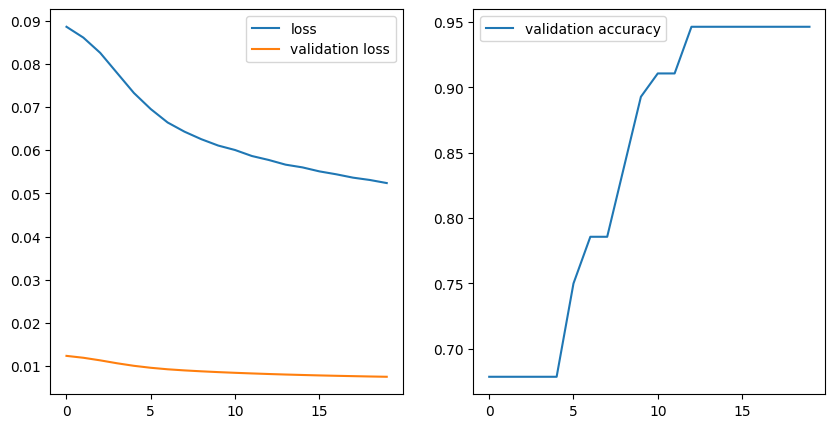

dropped: 0, test: loss: 0.42741402983665466, accuracy: 0.9534883499145508


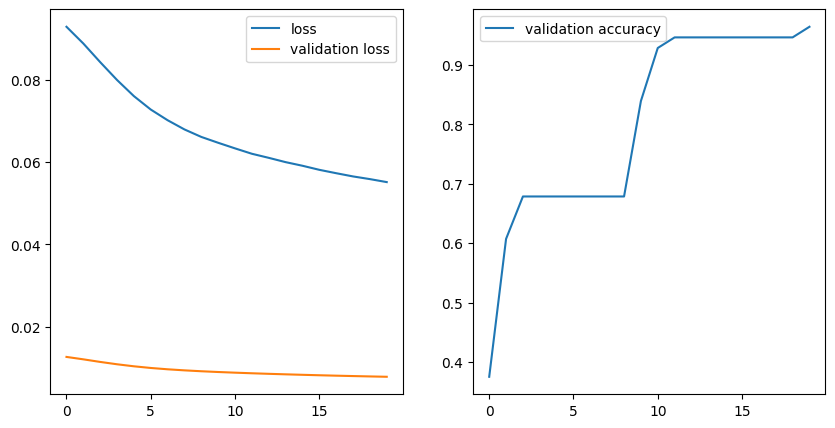

dropped: 1, test: loss: 0.4484131932258606, accuracy: 0.9593023061752319


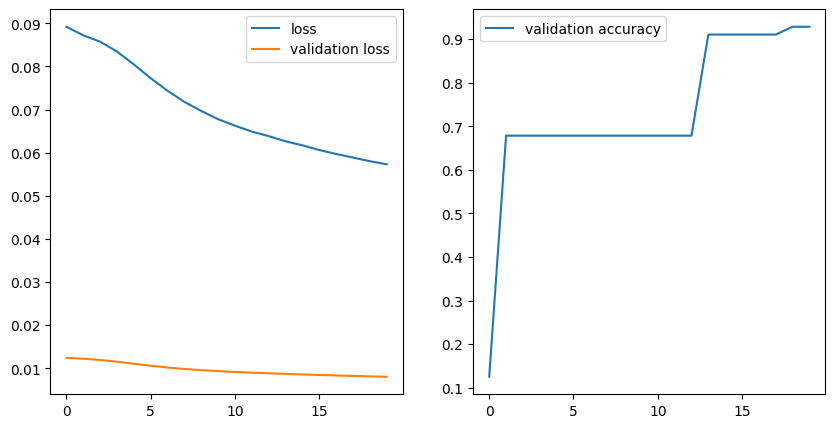

dropped: 2, test: loss: 0.46469998359680176, accuracy: 0.9593023061752319


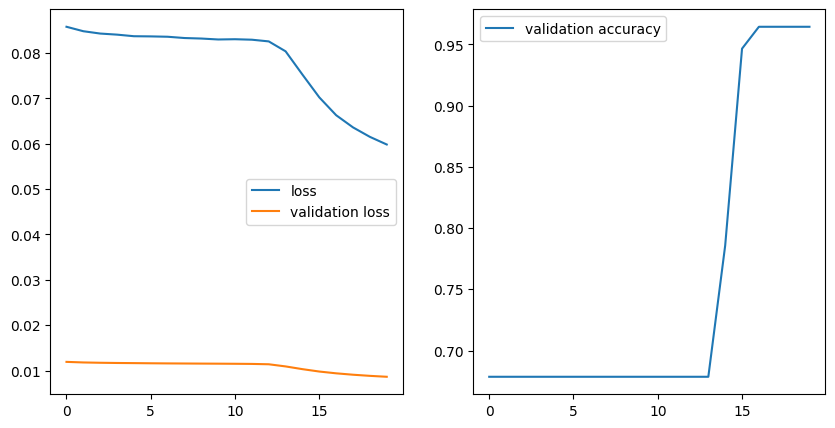

dropped: 3, test: loss: 0.46861886978149414, accuracy: 0.9767441749572754


In [245]:
# Layer 2
hs = 32 - num_drop_neurons
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: BreastCancerNN(x, (hs, y), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = fast_remove_neurons(reduced_datasets_neurons_layer1, hs, model_factory, optimizer_factory, criterion, False)